In [3]:
import pandas as pd 
import json
import numpy as np
import torch
import re
import os
import torch.nn.functional as F
def read_question_answer_file(file_path):
    """Reads a JSONL file with question-answer data and returns a list of dictionaries."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))  # Parse each line as JSON
    return data

# Load your dataset
# dataset_path = r'med_data/phrases_no_exclude_train.jsonl' 
dataset_path = r'C:\Users\ranad\OneDrive - University of Glasgow\Attachments\Msc Final Year project\Data\MedQA-USMLE-4-options\phrases_no_exclude_train.jsonl'
questions_data = read_question_answer_file(dataset_path)


print(questions_data[0]['question'])
print(questions_data[0]['answer_idx'])
print(questions_data[0]['options'])

A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral angle tenderness and a gravid uterus. Which of the following is the best treatment for this patient?
D
{'A': 'Ampicillin', 'B': 'Ceftriaxone', 'C': 'Doxycycline', 'D': 'Nitrofurantoin'}


In [4]:
def read_json_file(file_path):
  """Reads data from a JSON file.

  Args:
    file_path: The path to the JSON file.

  Returns:
    The parsed JSON data as a Python object.
  """

  with open(file_path, 'r') as f:
    data = json.load(f)
  return data

In [20]:
import torch
import numpy as np

def calculate_entropy(logits):
  """Calculates the entropy of a probability distribution.

  Args:
    logits: A tensor of logits.

  Returns:
    The entropy value.
  """

  probs = torch.softmax(logits, dim=-1)
  log_probs = torch.log(probs + 1e-9)  # Add small epsilon for numerical stability
  entropy = -(probs * log_probs).sum(dim=-1)
  return entropy.item()

# Example usage
logits = torch.tensor([0.6863, 0.0846, 0.0907, 0.1384])
entropy = calculate_entropy(logits)
print(entropy)

1.3488813638687134


In [6]:
data = read_json_file("Logit_scores\Pubmed_FIASS\llama_RAG_CS_Logit_20240820_024752.json")
data_baseline = read_json_file("Logit_scores\Baseline\llama_RAG_CS_Logit_20240820_115302.json")
data_wiki = read_json_file("Logit_scores\Wiki_doc\llama_RAG_CS_Logit_20240821_005005.json")

In [7]:
# data
# prob_options = [F.softmax(torch.tensor(logit), dim=0).tolist() for logit in data]
# prob_options

In [46]:
option_dict = {'0' : 'A', '1' : 'B', '2' : 'C', '3' : 'D' }

correct_prediction = 0
correct_positions = []
wrong_answer_positions = []
entrophy_values = []
question_length = []
corr_pred_prob50 = 0
model_pred_50 = 0
correct_pos_with_confidence = []

def getStats(data):
    global correct_prediction, correct_positions, wrong_answer_positions, \
    entrophy_values, question_length, corr_pred_prob50, correct_pos_with_confidence,model_pred_50
    # Setting the values for different datasets
    for i , question in enumerate(questions_data[:1000]):
        max_index = torch.argmax(torch.tensor(data[i])).item()
        max_value = torch.max(F.softmax(torch.tensor(data[i]), dim=0)).item()
        # Get the corresponding option from the dictionary
        predicted_option = option_dict[str(max_index)]
        question_length.append(len(question['question'].split()))
        entrophy_values.append(calculate_entropy(torch.tensor(data[i])))
        if (predicted_option == question['answer_idx'] ):
            correct_prediction += 1
            correct_positions.append(i)
            #correct_positions[str(i+1)] = F.softmax(torch.tensor(data[i]), dim=0).tolist()
        else:
            wrong_answer_positions.append(i)
        if max_value >= 0.9 :
            model_pred_50 +=1
            if (predicted_option == question['answer_idx'] ):
                corr_pred_prob50 +=1
                correct_pos_with_confidence.append(i)
                
                
getStats(data)
# getStats(data_baseline)
# getStats(data_wiki)

print("No of correct predictions: ", correct_prediction)
print("No of correct prediction with probability more than 50%: ", corr_pred_prob50)
print("No of questions with model probability more than 50% ", model_pred_50)
print("Correct questions with 80% model confidence:\n ", correct_pos_with_confidence)
# print("Wrong answers:\n",wrong_answer_positions)
print("Correct answers:\n",correct_positions)
# print("Entrophy values:\n", entrophy_values)

No of correct predictions:  466
No of correct prediction with probability more than 50%:  0
No of questions with model probability more than 50%  0
Correct questions with 80% model confidence:
  []
Correct answers:
 [1, 5, 6, 11, 12, 13, 14, 15, 20, 26, 27, 29, 31, 32, 33, 34, 35, 36, 43, 44, 46, 47, 49, 50, 51, 53, 58, 59, 61, 63, 65, 66, 67, 72, 74, 75, 76, 77, 79, 81, 82, 86, 87, 90, 91, 94, 96, 97, 98, 101, 102, 106, 108, 109, 111, 113, 115, 121, 122, 123, 124, 126, 127, 128, 130, 131, 135, 137, 138, 140, 144, 145, 146, 149, 150, 151, 152, 158, 160, 165, 166, 169, 171, 172, 175, 176, 177, 178, 180, 183, 184, 186, 187, 189, 190, 191, 195, 197, 198, 205, 206, 208, 210, 211, 214, 216, 218, 219, 220, 223, 228, 229, 233, 234, 235, 238, 239, 240, 243, 244, 245, 247, 248, 250, 252, 253, 256, 257, 259, 260, 262, 263, 266, 268, 270, 273, 275, 278, 280, 282, 284, 285, 287, 291, 293, 294, 296, 299, 303, 305, 309, 311, 313, 319, 320, 321, 324, 328, 329, 330, 331, 334, 336, 338, 341, 342, 344, 

In [22]:
certainty = [entrophy for entrophy in entrophy_values if entrophy <1.3]

In [23]:
# questions_data[245]
entrophy_pubmed =  [1.353952407836914, 1.172248363494873, 1.3437879085540771, 1.3629714250564575, 1.3072482347488403, 1.3549762964248657, 1.0508580207824707, 1.3586727380752563, 1.3216047286987305, 1.1764377355575562, 0.8436574339866638, 1.3263278007507324, 0.9881940484046936, 1.050452470779419, 1.2393635511398315, 1.355023741722107, 1.2426788806915283, 1.1852762699127197, 1.2077481746673584, 1.1200839281082153, 1.2670340538024902, 1.2356204986572266, 1.2967654466629028, 1.3621368408203125, 1.2268162965774536, 1.3726495504379272, 1.2425029277801514, 1.1710593700408936, 1.3461707830429077, 1.3394896984100342, 1.1949784755706787, 1.315420150756836, 1.349839687347412, 1.2240766286849976, 1.1269254684448242, 0.6737005710601807, 1.3724793195724487, 1.3077356815338135, 1.3810105323791504, 1.281579613685608, 1.3678171634674072, 1.3571947813034058, 1.3722469806671143, 1.2547249794006348, 1.3498375415802002, 1.204058289527893, 1.3273917436599731, 1.0775315761566162, 1.373795509338379, 1.2745757102966309, 1.11172616481781, 1.2370275259017944, 1.3675510883331299, 1.2987829446792603, 1.2862765789031982, 1.3537644147872925, 1.285586953163147, 1.2663311958312988, 1.2728173732757568, 1.336259365081787, 1.361201286315918, 1.290156602859497, 1.2633455991744995, 1.3473598957061768, 1.2401416301727295, 1.244537591934204, 1.193211555480957, 1.2549057006835938, 1.3532620668411255, 1.3548835515975952, 1.3636665344238281, 1.290769100189209, 1.241317868232727, 1.335383415222168, 1.1200428009033203, 1.3484692573547363, 1.3542075157165527, 1.1218281984329224, 1.384885549545288, 1.2446850538253784, 1.3511905670166016, 1.1827648878097534, 1.3684831857681274, 1.359941840171814, 1.3426687717437744, 1.3519415855407715, 1.3750545978546143, 1.2573273181915283, 1.2431968450546265, 1.323554277420044, 1.2961136102676392, 1.246305227279663, 1.377878189086914, 1.2303688526153564, 1.1918212175369263, 1.3607234954833984, 1.360267996788025, 0.9258226156234741, 1.3432722091674805, 1.3702982664108276, 1.3754668235778809, 1.3818559646606445, 1.2935619354248047, 1.3818323612213135, 1.2418193817138672, 1.3516120910644531, 1.3701251745224, 1.3168199062347412, 1.1519687175750732, 1.3157106637954712, 1.2847310304641724, 1.1223458051681519, 1.2544596195220947, 1.0452055931091309, 1.3748555183410645, 0.5653719902038574, 1.2382285594940186, 1.3507729768753052, 1.3337150812149048, 1.3426685333251953, 1.3368827104568481, 1.3540771007537842, 1.124761939048767, 1.3790336847305298, 1.3429820537567139, 1.3520153760910034, 1.3440043926239014, 0.8012465834617615, 1.1978018283843994, 1.3460122346878052, 1.2355694770812988, 0.9952529072761536, 1.3278815746307373, 1.2104023694992065, 1.3074278831481934, 1.3349159955978394, 0.971369743347168, 1.1344175338745117, 1.208216667175293, 1.3537421226501465, 1.320620059967041, 1.2758076190948486, 1.3529274463653564, 1.3803070783615112, 1.385908603668213, 1.0909415483474731, 1.2497096061706543, 1.142885446548462, 1.3387138843536377, 1.2812029123306274, 1.0784082412719727, 1.279280185699463, 1.1549859046936035, 1.316736102104187, 1.1910661458969116, 1.2313915491104126, 1.346745252609253, 1.3759510517120361, 1.256821870803833, 1.286176085472107, 1.3029024600982666, 1.377816915512085, 1.3257654905319214, 1.3329792022705078, 1.0634859800338745, 1.378004550933838, 1.2563968896865845, 1.2440534830093384, 1.10036301612854, 0.8459119200706482, 1.2753148078918457, 1.1990708112716675, 1.2507299184799194, 1.3218365907669067, 1.336107850074768, 1.3262633085250854, 1.1311293840408325, 1.3334003686904907, 1.1200538873672485, 1.3363244533538818, 1.0166263580322266, 1.3388299942016602, 1.3135569095611572, 1.241830587387085, 0.9064168930053711, 1.3440120220184326, 1.109646201133728, 1.3067550659179688, 1.2706458568572998, 0.5312675833702087, 1.2630707025527954, 1.3636574745178223, 1.342418909072876, 1.2634975910186768, 1.3620432615280151, 1.346806526184082, 1.3841444253921509, 1.3593095541000366, 1.2052536010742188, 1.2704064846038818, 1.2895780801773071, 1.3834978342056274, 1.1970369815826416, 1.2170213460922241, 1.2688292264938354, 1.1826417446136475, 1.3679090738296509, 1.2679669857025146, 1.2637320756912231, 1.2504081726074219, 1.127115249633789, 1.328648328781128, 1.3424961566925049, 1.3561173677444458, 1.0850368738174438, 1.3374443054199219, 1.264044165611267, 1.3546180725097656, 1.2907752990722656, 0.6626389026641846, 1.3418798446655273, 1.3191412687301636, 1.301291584968567, 1.1079720258712769, 1.157414197921753, 1.131892204284668, 1.2055730819702148, 1.290292501449585, 0.945267915725708, 0.9418860673904419, 1.2431542873382568, 1.3267366886138916, 1.372986912727356, 1.2467563152313232, 1.3590116500854492, 0.45598286390304565, 1.3483000993728638, 1.365859031677246, 1.3041526079177856, 1.2095928192138672, 1.2362339496612549, 1.343284010887146, 1.1735786199569702, 1.2705497741699219, 1.2582769393920898, 0.5589221119880676, 1.3561382293701172, 1.025131344795227, 0.9256572723388672, 1.3688883781433105, 0.8546468019485474, 1.3154388666152954, 1.2901020050048828, 1.0807549953460693, 1.3701058626174927, 1.3674964904785156, 0.9799801111221313, 1.1955487728118896, 1.250404715538025, 1.2557988166809082, 1.107045292854309, 1.3308515548706055, 1.2725313901901245, 0.7329095602035522, 1.2419583797454834, 1.140712022781372, 1.339958906173706, 1.3516583442687988, 1.3426200151443481, 1.1816446781158447, 1.2414696216583252, 1.316241979598999, 1.370110273361206, 1.3166015148162842, 0.9731608629226685, 1.209263563156128, 1.09539794921875, 1.1974384784698486, 1.3171517848968506, 1.1134355068206787, 0.9444899559020996, 1.3372173309326172, 1.3782262802124023, 1.3596607446670532, 1.3815820217132568, 1.115771770477295, 1.099150538444519, 1.110480785369873, 1.2802339792251587, 0.8985905051231384, 1.1702611446380615, 1.3791455030441284, 1.3587373495101929, 1.3220356702804565, 1.2899348735809326, 1.2489514350891113, 0.6523061990737915, 1.2050435543060303, 1.3024213314056396, 1.2596545219421387, 1.113592267036438, 1.3228057622909546, 1.2193351984024048, 1.3045130968093872, 1.335510492324829, 1.3400204181671143, 1.348881483078003, 1.2891371250152588, 1.3645575046539307, 1.3776909112930298, 1.3507399559020996, 0.9605546593666077, 1.1870989799499512, 0.7132952213287354, 1.3085649013519287, 1.3614650964736938, 1.3319158554077148, 1.3202263116836548, 1.0763267278671265, 1.2290714979171753, 1.3247140645980835, 1.3503116369247437, 1.3567490577697754, 1.3850438594818115, 1.2833374738693237, 1.373441219329834, 1.136847734451294, 0.9935551881790161, 1.0104053020477295, 0.6445916295051575, 0.9080324769020081, 1.3376002311706543, 1.281674861907959, 1.2850656509399414, 0.7879509329795837, 1.2166696786880493, 0.9891961812973022, 1.2614935636520386, 1.3463451862335205, 1.2621277570724487, 1.3319387435913086, 1.3412365913391113, 1.325263500213623, 1.3843621015548706, 1.0813617706298828, 1.2614418268203735, 1.3512938022613525, 1.1654045581817627, 1.2921587228775024, 0.6839611530303955, 1.3565086126327515, 1.3687365055084229, 0.6745944023132324, 1.2234175205230713, 1.3501777648925781, 1.336900234222412, 1.3656519651412964, 1.280091643333435, 1.3716199398040771, 1.2919793128967285, 1.2973034381866455, 1.288705587387085, 1.3590946197509766, 1.1864936351776123, 1.3305696249008179, 1.3113869428634644, 1.330233097076416, 1.3836311101913452, 1.2607983350753784, 1.325374722480774, 1.2380549907684326, 1.224848747253418, 1.3617939949035645, 1.3844150304794312, 1.3221555948257446, 1.3700469732284546, 0.9598158597946167, 1.3561081886291504, 1.2979103326797485, 1.2813854217529297, 1.297116994857788, 1.295222282409668, 1.3577841520309448, 1.3234150409698486, 1.2282640933990479, 1.3067742586135864, 1.1545686721801758, 1.237464189529419, 1.2284855842590332, 1.3096476793289185, 1.013540267944336, 1.3736408948898315, 1.3858976364135742, 1.2161341905593872, 1.349127173423767, 1.0695462226867676, 1.2552175521850586, 1.2287542819976807, 1.3101654052734375, 0.9507534503936768, 1.3807319402694702, 1.2275660037994385, 1.3371312618255615, 1.3819127082824707, 1.2942098379135132, 1.3748375177383423, 0.7753956317901611, 1.25412118434906, 1.1867403984069824, 1.2576125860214233, 0.9448874592781067, 0.7487427592277527, 1.218538761138916, 0.9752799272537231, 1.3412690162658691, 1.3464194536209106, 1.2161760330200195, 0.6565207242965698, 1.3483266830444336, 1.357756495475769, 1.3141824007034302, 1.2914012670516968, 0.8422743082046509, 1.3461228609085083, 1.2448183298110962, 1.3683280944824219, 1.2990111112594604, 1.3053014278411865, 1.1745768785476685, 1.3512699604034424, 1.3727941513061523, 1.3639423847198486, 1.3613990545272827, 1.1511704921722412, 0.911190390586853, 1.1516478061676025, 1.2392070293426514, 1.3326194286346436, 0.9682140350341797, 1.3802369832992554, 1.3532894849777222, 1.3336713314056396, 1.215165138244629, 1.3182897567749023, 1.3718619346618652, 1.1153703927993774, 1.278809905052185, 1.1491529941558838, 1.3781498670578003, 1.312168002128601, 1.2532411813735962, 0.892742395401001, 1.3212608098983765, 1.3567194938659668, 1.3337275981903076, 1.1701868772506714, 1.3258087635040283, 1.3342862129211426, 1.34941828250885, 1.2642887830734253, 1.3572287559509277, 1.2555631399154663, 1.3285248279571533, 1.2768356800079346, 1.2564139366149902, 1.3218269348144531, 1.131263017654419, 1.2213892936706543, 1.3041281700134277, 1.128933310508728, 1.2195916175842285, 1.375900149345398, 1.2212928533554077, 1.318223237991333, 1.2743805646896362, 1.3424936532974243, 1.186386227607727, 1.2687115669250488, 1.2326582670211792, 1.3678241968154907, 1.3504287004470825, 0.8829901218414307, 1.31128990650177, 1.095146894454956, 1.368311882019043, 1.2723597288131714, 1.2777988910675049, 1.337745189666748, 1.377641201019287, 1.3522387742996216, 1.324127435684204, 1.3642351627349854, 1.3216114044189453, 1.3717633485794067, 1.3833366632461548, 0.9280933141708374, 1.3156054019927979, 1.2980315685272217, 1.3847699165344238, 1.3659167289733887, 1.2541332244873047, 1.3651628494262695, 0.8375229835510254, 0.6521633863449097, 0.6520331501960754, 1.2648450136184692, 1.379323959350586, 1.381998896598816, 1.339369535446167, 0.8029671311378479, 1.3233363628387451, 1.316519021987915, 1.3023104667663574, 1.2811033725738525, 1.3512014150619507, 1.1125497817993164, 1.0755298137664795, 0.9098839163780212, 1.2194404602050781, 1.376889944076538, 1.1757843494415283, 1.2898313999176025, 1.362560510635376, 1.3071846961975098, 1.3360047340393066, 1.2625911235809326, 1.207961082458496, 1.3789926767349243, 1.301727056503296, 1.3020212650299072, 1.226516604423523, 1.3069530725479126, 1.374297857284546, 1.3236382007598877, 1.3786112070083618, 1.1210001707077026, 1.2958173751831055, 1.348392128944397, 1.3521978855133057, 1.2421156167984009, 0.8811189532279968, 1.34500253200531, 1.3563076257705688, 1.2301139831542969, 1.3248286247253418, 1.362581491470337, 1.144302487373352, 1.0762286186218262, 1.3005906343460083, 1.3099268674850464, 1.1501092910766602, 1.3709489107131958, 1.2830688953399658, 1.2429699897766113, 1.2466650009155273, 1.0965040922164917, 1.340018391609192, 1.3366446495056152, 1.208573579788208, 1.3444170951843262, 1.238603115081787, 1.3299624919891357, 1.214346170425415, 1.3056440353393555, 1.1880881786346436, 1.0467838048934937, 1.3799482583999634, 1.0996967554092407, 1.2745320796966553, 1.1864688396453857, 1.2477930784225464, 1.0061942338943481, 0.9762213230133057, 1.3517533540725708, 0.9294308423995972, 1.3701486587524414, 1.33735990524292, 1.3256934881210327, 1.3442108631134033, 1.3733904361724854, 1.324495792388916, 1.3455097675323486, 0.5247124433517456, 1.353287935256958, 1.356019139289856, 1.364420771598816, 1.3172011375427246, 1.2110259532928467, 1.280839204788208, 0.9687644243240356, 1.1502323150634766, 1.2264527082443237, 1.240473985671997, 0.7850008606910706, 1.3639336824417114, 1.2707345485687256, 1.2531962394714355, 1.365140438079834, 0.9159120321273804, 1.2373497486114502, 1.074756145477295, 1.0118672847747803, 1.3088853359222412, 1.0504286289215088, 1.179207444190979, 1.2066638469696045, 1.3009533882141113, 0.9834187030792236, 1.3322224617004395, 1.3592913150787354, 1.263411521911621, 1.3250960111618042, 1.0527397394180298, 1.0605958700180054, 1.1890610456466675, 1.307999610900879, 1.1525828838348389, 1.2872580289840698, 1.2902438640594482, 1.3731588125228882, 0.961548388004303, 1.1021721363067627, 1.3834259510040283, 1.1674656867980957, 1.1106529235839844, 1.3331252336502075, 1.174600601196289, 1.15114426612854, 1.3774316310882568, 1.3519177436828613, 1.3071513175964355, 1.3510453701019287, 1.265454888343811, 1.3751856088638306, 1.212038516998291, 0.9078327417373657, 1.3291008472442627, 1.182900071144104, 1.2641527652740479, 1.182682991027832, 1.0124703645706177, 1.2601468563079834, 1.330810546875, 1.1514981985092163, 1.328079342842102, 1.361859917640686, 1.290320634841919, 1.1084952354431152, 1.2316814661026, 1.2617439031600952, 0.5336562395095825, 1.3657844066619873, 1.3603816032409668, 0.9833476543426514, 1.3453214168548584, 1.30694580078125, 1.3710460662841797, 1.0546340942382812, 1.1869596242904663, 1.3170238733291626, 1.3510732650756836, 1.3388910293579102, 1.3176287412643433, 1.3256468772888184, 1.2652353048324585, 1.1794824600219727, 1.3333314657211304, 1.3669836521148682, 1.2918078899383545, 1.2540215253829956, 0.8666084408760071, 1.3240454196929932, 0.552463710308075, 1.3529099225997925, 1.0671696662902832, 1.3384038209915161, 1.063270926475525, 1.2699215412139893, 1.278915524482727, 1.1703169345855713, 1.1695919036865234, 1.2046908140182495, 1.367677927017212, 1.332085371017456, 1.3623745441436768, 1.3339154720306396, 1.0117685794830322, 1.379827618598938, 1.3786543607711792, 1.0752679109573364, 0.8045276403427124, 1.22703218460083, 1.2753431797027588, 1.3426649570465088, 1.1151396036148071, 1.3559831380844116, 1.2414658069610596, 1.122246265411377, 1.1456633806228638, 1.3175283670425415, 1.1866497993469238, 1.3758811950683594, 1.289655089378357, 1.3388628959655762, 1.3603743314743042, 1.1749742031097412, 1.0683162212371826, 1.377427101135254, 1.3220399618148804, 1.3683497905731201, 1.298750877380371, 1.3209501504898071, 1.269331693649292, 0.9687920212745667, 1.2311975955963135, 1.34512197971344, 1.2467951774597168, 1.2310755252838135, 1.3754494190216064, 1.2220394611358643, 1.1591320037841797, 1.3110815286636353, 1.2523181438446045, 1.2015610933303833, 1.1651756763458252, 1.314962387084961, 1.353177547454834, 1.316607117652893, 1.3649168014526367, 1.278652310371399, 1.0936815738677979, 1.1889110803604126, 1.0967329740524292, 1.3795326948165894, 1.3068665266036987, 1.0601996183395386, 1.2380303144454956, 1.2980048656463623, 1.268222689628601, 1.3560373783111572, 1.2841224670410156, 1.3446401357650757, 1.0774896144866943, 1.0840160846710205, 1.2800722122192383, 1.32059907913208, 1.2893537282943726, 1.3042563199996948, 1.3237851858139038, 1.2745304107666016, 1.297843098640442, 0.9119372367858887, 1.1691277027130127, 1.3803341388702393, 1.3091660737991333, 1.213468074798584, 0.8995883464813232, 1.0603153705596924, 0.8935118913650513, 1.2174084186553955, 1.2616944313049316, 1.2634389400482178, 1.257718563079834, 1.2427117824554443, 1.1850336790084839, 1.332672357559204, 1.0939993858337402, 1.3686203956604004, 1.3787622451782227, 1.3678748607635498, 1.3571300506591797, 0.6696798205375671, 1.353588581085205, 1.3457865715026855, 1.3144915103912354, 1.3128225803375244, 1.265478491783142, 1.3127479553222656, 1.2455726861953735, 1.3091682195663452, 1.310158610343933, 1.3047488927841187, 1.2848761081695557, 1.2176225185394287, 1.3623379468917847, 1.2712329626083374, 1.254054069519043, 1.2682933807373047, 1.3724043369293213, 1.2995631694793701, 1.3560271263122559, 1.3726956844329834, 1.1732553243637085, 1.302922248840332, 0.7416820526123047, 1.2565349340438843, 1.3750046491622925, 1.3158624172210693, 1.2266690731048584, 1.3288936614990234, 0.7567019462585449, 1.3684618473052979, 1.3633654117584229, 1.2486892938613892, 1.1177117824554443, 1.0333117246627808, 1.3527988195419312, 1.2123427391052246, 1.3303616046905518, 1.362534999847412, 1.3501800298690796, 1.3661329746246338, 1.2738438844680786, 1.1493589878082275, 1.283226490020752, 1.3362367153167725, 1.3441762924194336, 1.3805793523788452, 1.2684928178787231, 1.2796235084533691, 1.2203160524368286, 1.373458743095398, 1.308655858039856, 1.2613582611083984, 1.3571224212646484, 1.2228431701660156, 0.862341046333313, 1.340156078338623, 1.0848960876464844, 1.377159595489502, 1.1393388509750366, 1.275239109992981, 1.362730860710144, 1.2887130975723267, 1.1059070825576782, 1.3350439071655273, 0.9776008129119873, 1.319868564605713, 1.236090064048767, 1.3595905303955078, 1.3397831916809082, 1.35013747215271, 1.169649600982666, 1.3664071559906006, 1.2597315311431885, 1.0387110710144043, 1.3057509660720825, 1.2966041564941406, 1.2974578142166138, 1.310430645942688, 1.1325640678405762, 1.1570863723754883, 1.1965131759643555, 1.3015676736831665, 1.2556679248809814, 1.3833926916122437, 1.272615909576416, 1.2755550146102905, 0.9741699695587158, 1.347119927406311, 1.2499653100967407, 1.327782154083252, 0.9113807082176208, 1.2969475984573364, 1.2519243955612183, 1.2392183542251587, 1.3382092714309692, 1.1851009130477905, 1.2590835094451904, 1.0847021341323853, 1.3577077388763428, 1.1797008514404297, 1.360005259513855, 1.2468458414077759, 1.0797407627105713, 1.122847557067871, 1.297023892402649, 1.3056116104125977, 1.0941853523254395, 1.327976107597351, 1.3514108657836914, 1.3420844078063965, 1.021979808807373, 1.2438746690750122, 1.237004280090332, 1.353778600692749, 1.3335797786712646, 0.9953875541687012, 1.3543126583099365, 1.3807957172393799, 1.336426019668579, 1.3501904010772705, 1.0127499103546143, 1.040123462677002, 1.2303977012634277, 1.363577961921692, 1.325160264968872, 1.250159502029419, 1.3317601680755615, 1.295242190361023, 1.3036681413650513, 1.3823058605194092, 1.372471570968628, 1.381608486175537, 1.176025390625, 1.1826422214508057, 1.2770777940750122, 1.2411645650863647, 1.2437795400619507, 1.2141016721725464, 1.2874932289123535, 1.1504427194595337, 1.1308486461639404, 1.2086073160171509, 1.3693413734436035, 1.3628937005996704, 1.1446938514709473, 1.2160096168518066, 1.19065260887146, 1.2448086738586426, 1.3019680976867676, 1.163658618927002, 0.9715235829353333, 1.3740195035934448, 1.2271054983139038, 1.129075288772583, 1.2173937559127808, 1.1536632776260376, 1.2394583225250244, 1.313284993171692, 1.2623939514160156, 1.3462170362472534, 1.2791986465454102, 1.3135604858398438, 1.2296931743621826, 1.319648027420044, 1.2500380277633667, 1.2667081356048584, 1.3607075214385986, 1.3091286420822144, 1.3410322666168213, 1.3019051551818848, 1.1207588911056519, 1.329941749572754, 1.1042132377624512, 1.3711488246917725, 1.223179817199707, 1.1210851669311523, 1.333133339881897, 1.2231301069259644, 1.1326520442962646, 1.3580131530761719, 1.3711206912994385, 1.3481135368347168, 1.1867694854736328, 1.0746556520462036, 1.1856069564819336, 1.1266084909439087, 1.3602977991104126, 0.8536747694015503, 1.2793768644332886, 1.3561493158340454, 1.2917922735214233, 1.2061612606048584, 1.3519203662872314, 1.213428258895874, 1.3617538213729858, 1.1164883375167847, 1.255408525466919, 1.2981737852096558, 1.3556256294250488, 0.6657396554946899, 0.815151572227478, 1.1664564609527588, 1.2902615070343018, 1.3514001369476318, 1.3597996234893799, 1.3582923412322998, 1.2696624994277954, 1.346314787864685, 0.7210140228271484, 1.0854287147521973, 1.3284509181976318, 1.1059645414352417, 0.9586355686187744, 1.0975303649902344, 1.0079666376113892, 1.20582115650177, 1.3476018905639648, 1.2674386501312256, 0.9949784278869629, 1.0576635599136353, 1.2944127321243286, 1.113634467124939, 1.352550983428955, 1.30610990524292, 1.25046968460083, 1.3367440700531006, 1.0520062446594238, 1.3700677156448364]
entrophy_wiki = [1.2639693021774292, 1.1413333415985107, 1.162664532661438, 1.307222604751587, 0.7893624305725098, 1.3577885627746582, 0.8628368973731995, 1.1668394804000854, 1.2834727764129639, 1.0686180591583252, 1.3053758144378662, 0.8288981318473816, 1.2190968990325928, 1.13340425491333, 0.9603238105773926, 1.284702181816101, 1.1135058403015137, 1.1444900035858154, 1.2222644090652466, 1.1057207584381104, 1.2467455863952637, 1.314488172531128, 0.5736223459243774, 1.1486968994140625, 1.1778805255889893, 1.3786845207214355, 1.2872605323791504, 1.3232980966567993, 1.2524927854537964, 1.2356276512145996, 1.3419767618179321, 1.2195500135421753, 1.1023012399673462, 1.3562037944793701, 1.0554524660110474, 0.34290480613708496, 1.0971940755844116, 1.3210864067077637, 1.3763453960418701, 1.2897402048110962, 1.3481415510177612, 1.3385546207427979, 1.2799279689788818, 1.295592188835144, 1.2858352661132812, 1.37001633644104, 1.3089449405670166, 1.143958568572998, 1.3645542860031128, 1.2945632934570312, 1.1683406829833984, 1.2548518180847168, 1.3016890287399292, 1.3517048358917236, 1.2826719284057617, 1.1057170629501343, 0.9674056172370911, 1.202717661857605, 1.2689571380615234, 1.3035273551940918, 1.3660187721252441, 1.2603979110717773, 0.9883722066879272, 0.9898921251296997, 1.1048195362091064, 1.0768067836761475, 1.129869818687439, 1.1689766645431519, 1.297671914100647, 1.0715702772140503, 1.3444139957427979, 1.06940495967865, 1.0696393251419067, 1.2848937511444092, 1.0722520351409912, 1.3704326152801514, 1.1811412572860718, 0.9387276768684387, 1.273190975189209, 1.2526891231536865, 1.3032290935516357, 0.6265518069267273, 1.3319884538650513, 1.340194582939148, 1.2558479309082031, 1.1115422248840332, 1.2352685928344727, 1.1766825914382935, 1.2391167879104614, 1.3440234661102295, 1.1658669710159302, 1.3211373090744019, 1.3784385919570923, 1.0737025737762451, 1.1043128967285156, 1.2104012966156006, 1.386103630065918, 0.8898059129714966, 1.1628094911575317, 1.3732547760009766, 1.206619381904602, 1.3784971237182617, 1.2859079837799072, 1.3514556884765625, 0.9130274057388306, 1.321258783340454, 1.1235761642456055, 1.2138237953186035, 0.9712408781051636, 1.1066927909851074, 1.1194199323654175, 1.2705806493759155, 1.192262053489685, 1.178626537322998, 1.2933114767074585, 0.4769924283027649, 1.241145133972168, 1.31758713722229, 1.3103547096252441, 1.348385214805603, 1.2747362852096558, 1.2802577018737793, 1.086439847946167, 1.1713476181030273, 1.3804792165756226, 1.3434913158416748, 1.3088246583938599, 0.6382778882980347, 1.23978590965271, 1.16452157497406, 1.213199257850647, 1.0559766292572021, 1.1780709028244019, 1.19115149974823, 1.217623233795166, 1.2827465534210205, 1.026463508605957, 1.0850105285644531, 0.9669673442840576, 1.2789278030395508, 0.9274999499320984, 1.2227563858032227, 1.3006950616836548, 1.3494431972503662, 1.3834646940231323, 0.886781632900238, 1.3386083841323853, 1.1133136749267578, 1.3729193210601807, 1.255614161491394, 0.6576739549636841, 1.362743616104126, 1.1356111764907837, 1.369325041770935, 1.1779617071151733, 1.3048012256622314, 1.200832486152649, 1.3030942678451538, 1.2200322151184082, 1.301346778869629, 1.3016053438186646, 1.346830129623413, 1.1947358846664429, 1.3200143575668335, 0.9955428242683411, 1.3828387260437012, 1.2257024049758911, 0.8684065341949463, 1.0928515195846558, 0.628873884677887, 1.2052652835845947, 1.2252026796340942, 1.26019287109375, 1.138678789138794, 1.032827615737915, 1.3564517498016357, 0.9483535885810852, 1.1276910305023193, 0.6259176135063171, 1.257836937904358, 0.48992598056793213, 1.0986063480377197, 1.3216285705566406, 0.797143816947937, 1.1175576448440552, 1.127580165863037, 1.0959802865982056, 1.3063316345214844, 0.9048898220062256, 0.5742222666740417, 1.3239846229553223, 1.2312668561935425, 1.1917692422866821, 1.0485931634902954, 1.1920315027236938, 1.32041335105896, 1.3766536712646484, 1.2818243503570557, 1.2208127975463867, 1.2099310159683228, 1.1311101913452148, 1.3187388181686401, 1.2793375253677368, 1.2447013854980469, 1.042240023612976, 1.3123763799667358, 1.372989535331726, 0.9177953004837036, 1.2964582443237305, 0.9398462772369385, 1.1778433322906494, 1.127124547958374, 1.334289312362671, 1.2689976692199707, 0.9668437242507935, 1.173170804977417, 1.0340569019317627, 1.1632795333862305, 1.209733486175537, 0.7242546677589417, 1.2760430574417114, 1.3463393449783325, 1.29695463180542, 0.8782996535301208, 1.1859632730484009, 1.126214623451233, 1.245344638824463, 1.2507613897323608, 0.8701836466789246, 0.8885825872421265, 1.1544828414916992, 0.8482075929641724, 0.8490819334983826, 1.0008405447006226, 1.1392796039581299, 0.5414599180221558, 1.3554764986038208, 1.3724415302276611, 1.274185061454773, 1.0110549926757812, 1.2121076583862305, 1.3430901765823364, 0.9733403921127319, 0.9572005271911621, 1.311600685119629, 0.6871470212936401, 1.2033990621566772, 0.909276008605957, 1.001913070678711, 1.3520655632019043, 1.1030967235565186, 1.2822805643081665, 1.3617167472839355, 1.189091682434082, 1.3669075965881348, 1.1908293962478638, 1.193475604057312, 0.7231197357177734, 1.2549476623535156, 1.2534615993499756, 0.7248395681381226, 1.0509220361709595, 1.0864285230636597, 0.8593260049819946, 0.8748477697372437, 1.0814595222473145, 1.2162096500396729, 1.1858808994293213, 1.3475019931793213, 1.186213493347168, 0.9532156586647034, 1.1456358432769775, 0.9288668632507324, 1.1255310773849487, 1.2441678047180176, 1.0414023399353027, 1.126861810684204, 0.5426084995269775, 0.9164074659347534, 0.8411900997161865, 1.1289631128311157, 1.2653954029083252, 1.383674144744873, 1.3664753437042236, 1.0095040798187256, 0.941740870475769, 0.9566996097564697, 1.0225145816802979, 1.3291454315185547, 1.0144867897033691, 0.9712852239608765, 1.3737974166870117, 1.3550176620483398, 1.326072096824646, 1.2425048351287842, 0.7455763816833496, 1.0956084728240967, 0.806853711605072, 0.9772279262542725, 1.2714226245880127, 1.2200068235397339, 1.0874648094177246, 0.988289475440979, 1.1554014682769775, 1.1533626317977905, 1.340641975402832, 1.2912473678588867, 1.3569459915161133, 1.2759716510772705, 1.2469401359558105, 1.3535881042480469, 1.0734554529190063, 0.7918944358825684, 1.1253130435943604, 1.2953016757965088, 1.2855110168457031, 1.2167654037475586, 1.2038521766662598, 1.2830915451049805, 1.2705497741699219, 1.1913284063339233, 1.205207109451294, 1.3507988452911377, 1.3446967601776123, 1.2404758930206299, 1.3463512659072876, 0.7876043319702148, 0.8750836253166199, 0.9667117595672607, 1.1565415859222412, 0.945617139339447, 1.2886906862258911, 1.3133859634399414, 1.2555307149887085, 0.8848416805267334, 1.273628830909729, 1.2213999032974243, 0.9945118427276611, 1.3470196723937988, 1.085884928703308, 1.3757517337799072, 1.3607189655303955, 1.2765483856201172, 1.305965542793274, 1.3058862686157227, 1.2547831535339355, 1.359486699104309, 1.2006628513336182, 1.2633219957351685, 0.9402191638946533, 1.363340973854065, 1.3610796928405762, 0.8186377286911011, 0.8017933964729309, 1.3325293064117432, 1.3093127012252808, 1.3658161163330078, 1.2692242860794067, 1.2474181652069092, 1.332351803779602, 0.5532582402229309, 1.284728765487671, 1.173553466796875, 1.3124668598175049, 1.3357868194580078, 1.2908931970596313, 1.1435285806655884, 1.3602079153060913, 1.2386350631713867, 1.2265064716339111, 0.5325350165367126, 1.242553949356079, 1.3261427879333496, 1.303828477859497, 1.1514705419540405, 1.3271260261535645, 1.0775724649429321, 1.0942920446395874, 1.0247811079025269, 1.3384675979614258, 1.3662601709365845, 1.3475675582885742, 1.3268113136291504, 1.3044747114181519, 1.1774678230285645, 1.1507518291473389, 1.0426033735275269, 1.2573602199554443, 1.2223143577575684, 1.337720274925232, 1.0197653770446777, 1.3587607145309448, 1.334510326385498, 1.1693819761276245, 1.2751846313476562, 0.973991870880127, 1.221069574356079, 1.0685802698135376, 1.3688429594039917, 1.221390724182129, 1.3077480792999268, 1.3249351978302002, 1.2494546175003052, 1.2747399806976318, 1.1287387609481812, 1.325987458229065, 1.2625155448913574, 1.0951533317565918, 0.9176961779594421, 1.2897748947143555, 0.9280900955200195, 0.860987663269043, 1.2214668989181519, 0.9338536858558655, 1.3169066905975342, 1.1455472707748413, 1.165163278579712, 1.1453721523284912, 1.230906367301941, 1.3405818939208984, 1.3815118074417114, 1.3205108642578125, 0.8730618357658386, 1.2924000024795532, 1.2303158044815063, 1.3418885469436646, 1.0402249097824097, 1.1850306987762451, 1.116217851638794, 1.3157265186309814, 1.266791582107544, 1.3034007549285889, 1.2838389873504639, 1.316347599029541, 1.0787354707717896, 1.1869065761566162, 1.3248382806777954, 1.180716872215271, 1.1840269565582275, 1.384999394416809, 1.3528854846954346, 1.3163172006607056, 1.266233205795288, 1.278590440750122, 0.9756680130958557, 1.2478971481323242, 1.0497922897338867, 1.1828186511993408, 1.3289570808410645, 1.3411879539489746, 1.2257285118103027, 1.184382438659668, 1.2151641845703125, 1.2665870189666748, 1.2532824277877808, 0.6546778678894043, 1.3193398714065552, 1.225543737411499, 1.2919867038726807, 0.8394559621810913, 1.1831703186035156, 1.005593180656433, 1.09297513961792, 0.509305477142334, 1.2127704620361328, 1.262808918952942, 1.1731377840042114, 1.2519605159759521, 1.255794644355774, 1.1607789993286133, 1.308558464050293, 1.2041471004486084, 1.2123037576675415, 1.1050810813903809, 1.2857064008712769, 1.2607375383377075, 1.231414794921875, 0.9272912740707397, 0.8923079967498779, 1.3015272617340088, 1.3019912242889404, 0.9525233507156372, 1.3474842309951782, 1.1457226276397705, 1.3498883247375488, 1.071012258529663, 1.3070225715637207, 1.1973017454147339, 1.0209722518920898, 1.3438339233398438, 1.198216438293457, 1.295435905456543, 1.0346201658248901, 1.1489161252975464, 1.3330105543136597, 0.9684816598892212, 1.3573737144470215, 1.2769594192504883, 1.3772063255310059, 1.363289713859558, 1.192384123802185, 1.3514705896377563, 0.860745906829834, 1.157212495803833, 0.31308597326278687, 0.5198432207107544, 1.0596249103546143, 1.3835020065307617, 1.3404061794281006, 1.2529239654541016, 1.2357113361358643, 1.2706615924835205, 1.2275762557983398, 1.2966333627700806, 1.3586300611495972, 1.2663806676864624, 1.0292571783065796, 0.3505846858024597, 1.2886873483657837, 1.3841545581817627, 1.1806645393371582, 1.3680447340011597, 1.2704963684082031, 1.3835036754608154, 1.24081289768219, 1.2247182130813599, 1.264890432357788, 1.3530141115188599, 1.1994234323501587, 1.2815433740615845, 1.2851738929748535, 1.140002965927124, 1.3612134456634521, 1.0057642459869385, 1.2253637313842773, 1.1041340827941895, 1.1990658044815063, 1.3126099109649658, 1.098587989807129, 1.3332213163375854, 1.149515986442566, 1.3413612842559814, 1.2676894664764404, 0.9571012854576111, 1.3183693885803223, 1.3199162483215332, 0.8333116769790649, 0.8358134031295776, 1.3599432706832886, 1.2762479782104492, 1.057069182395935, 1.3026392459869385, 1.3024561405181885, 1.1432087421417236, 1.279477834701538, 1.3085167407989502, 1.1740639209747314, 1.348285436630249, 1.0729930400848389, 1.3130903244018555, 1.1137630939483643, 1.2774766683578491, 0.9564651250839233, 1.069812536239624, 1.211395502090454, 1.1733918190002441, 1.3498878479003906, 1.0645959377288818, 1.1104085445404053, 1.275924801826477, 1.23475980758667, 0.8471531867980957, 1.0259562730789185, 1.2405339479446411, 0.713026762008667, 1.3795291185379028, 1.320326328277588, 0.8028728365898132, 1.263012409210205, 1.301804542541504, 1.361249566078186, 1.2835240364074707, 0.49080944061279297, 1.278823733329773, 1.0808078050613403, 1.348586082458496, 1.3238530158996582, 1.10062575340271, 1.2772643566131592, 0.7729034423828125, 0.8891364336013794, 1.177358865737915, 0.9520951509475708, 0.8705224394798279, 1.2166266441345215, 1.2578401565551758, 1.2424941062927246, 1.3396247625350952, 0.8206093907356262, 1.3776460886001587, 1.113950252532959, 1.0134471654891968, 1.2560172080993652, 1.3091497421264648, 1.224410057067871, 1.2701119184494019, 1.3827247619628906, 1.3005191087722778, 1.3376681804656982, 1.2575254440307617, 1.2767467498779297, 1.171257734298706, 1.1676273345947266, 0.9451686143875122, 1.1242114305496216, 1.3108594417572021, 1.233814001083374, 1.3349075317382812, 1.1493077278137207, 1.3475227355957031, 1.2417081594467163, 1.1449812650680542, 1.1702817678451538, 1.1785192489624023, 1.1711094379425049, 1.2971196174621582, 1.1021108627319336, 1.343141794204712, 0.9479960203170776, 1.349256157875061, 1.2762670516967773, 0.7404653429985046, 0.9286993145942688, 1.3823682069778442, 0.8744484186172485, 0.827742338180542, 1.181410551071167, 1.1254481077194214, 1.177544116973877, 1.374594807624817, 1.0490624904632568, 1.325225591659546, 1.3099186420440674, 0.7272127270698547, 0.8590364456176758, 1.2192270755767822, 1.2119123935699463, 0.7994386553764343, 1.0378544330596924, 1.2842381000518799, 0.5731600522994995, 1.3504819869995117, 1.311837911605835, 1.0123436450958252, 1.174141526222229, 1.2096515893936157, 1.2490332126617432, 1.220343828201294, 1.1434091329574585, 1.0903178453445435, 1.3478931188583374, 1.3310359716415405, 1.183931589126587, 1.0918084383010864, 1.26762855052948, 1.2853925228118896, 1.2900007963180542, 1.1940419673919678, 1.308366060256958, 1.1921353340148926, 0.7052547931671143, 1.3064584732055664, 0.5361489653587341, 1.2916476726531982, 1.0026353597640991, 1.3738551139831543, 1.2545808553695679, 1.2613794803619385, 1.3340150117874146, 1.1335786581039429, 1.1972005367279053, 1.0071165561676025, 1.3024213314056396, 1.3138028383255005, 1.3482298851013184, 1.3201725482940674, 0.9459245800971985, 1.381899118423462, 1.2651387453079224, 0.7715442776679993, 0.7707326412200928, 0.9900522828102112, 1.2341063022613525, 1.3214740753173828, 1.2378523349761963, 1.1209776401519775, 1.2324801683425903, 0.8637494444847107, 0.9916066527366638, 1.1850128173828125, 1.20011305809021, 1.3726227283477783, 1.2042980194091797, 1.247633695602417, 1.3225862979888916, 0.8163062334060669, 0.8407256603240967, 1.2515616416931152, 1.1916968822479248, 1.1836535930633545, 1.2906208038330078, 1.1959196329116821, 1.2163918018341064, 1.1987566947937012, 1.3234949111938477, 1.179262399673462, 1.1024796962738037, 1.201212763786316, 1.1345937252044678, 1.236677885055542, 0.948491632938385, 1.1616690158843994, 1.355989933013916, 1.1817448139190674, 0.5117583274841309, 1.2858288288116455, 1.0904148817062378, 1.080611228942871, 1.3618278503417969, 1.0985393524169922, 1.1694610118865967, 1.0374743938446045, 1.2659274339675903, 1.3510534763336182, 1.1837652921676636, 0.6055871844291687, 0.859224796295166, 1.3626699447631836, 1.0966768264770508, 1.3576273918151855, 1.3571734428405762, 1.3350220918655396, 1.0655953884124756, 0.9768326282501221, 1.2751617431640625, 1.3289494514465332, 1.2534644603729248, 1.2819461822509766, 1.303093433380127, 1.340944528579712, 1.1935447454452515, 1.169847011566162, 1.2653754949569702, 1.3373386859893799, 1.0688741207122803, 1.1980326175689697, 1.0749073028564453, 1.0762218236923218, 1.0983433723449707, 1.1920561790466309, 1.2509162425994873, 1.2861191034317017, 0.9889299869537354, 1.2706341743469238, 1.3286731243133545, 1.1447752714157104, 1.1544404029846191, 1.1462697982788086, 1.3748029470443726, 1.345465064048767, 1.3341929912567139, 0.853191614151001, 1.2724440097808838, 1.171936273574829, 1.297703742980957, 1.3397283554077148, 0.7355256676673889, 1.320878267288208, 1.124558448791504, 0.9095358848571777, 1.3007241487503052, 1.2333818674087524, 1.3559800386428833, 1.303420066833496, 1.2942311763763428, 1.2194397449493408, 1.3118772506713867, 1.1713517904281616, 1.1512306928634644, 1.3208507299423218, 1.3195477724075317, 1.118154764175415, 0.9370257258415222, 1.0918325185775757, 0.73820561170578, 1.1972477436065674, 1.3542771339416504, 1.335740089416504, 1.2398978471755981, 1.1534377336502075, 1.2107582092285156, 1.3189713954925537, 1.2997684478759766, 0.7447290420532227, 1.3035142421722412, 1.2899787425994873, 1.3273358345031738, 1.1165989637374878, 1.3598476648330688, 1.3766686916351318, 1.353869915008545, 1.350279688835144, 1.1042181253433228, 0.8785277605056763, 1.3156673908233643, 1.2047460079193115, 1.2048044204711914, 1.3647236824035645, 1.344139575958252, 1.3554167747497559, 1.0362334251403809, 1.296393632888794, 1.3484193086624146, 1.3243426084518433, 1.1483492851257324, 1.3558319807052612, 1.1292515993118286, 1.3437566757202148, 1.1253528594970703, 1.2963725328445435, 0.6936131715774536, 1.1230242252349854, 1.065471887588501, 1.3161119222640991, 1.1047887802124023, 1.323409914970398, 1.1486666202545166, 0.978411853313446, 1.2884219884872437, 1.3461910486221313, 1.329552173614502, 1.3521512746810913, 1.146681785583496, 1.315352439880371, 1.090420126914978, 1.0626546144485474, 1.2640445232391357, 1.1332354545593262, 1.3343279361724854, 1.1840654611587524, 1.3189927339553833, 0.7871605157852173, 1.1401963233947754, 1.058742880821228, 1.2534288167953491, 1.3052332401275635, 1.235484004020691, 0.948218047618866, 1.3152239322662354, 1.3032824993133545, 1.2113285064697266, 1.3034477233886719, 0.9949058890342712, 1.0870553255081177, 1.2873319387435913, 1.1995106935501099, 1.3674415349960327, 1.1814996004104614, 1.3116079568862915, 0.9264093637466431, 1.2994976043701172, 1.2330788373947144, 1.319970726966858, 1.3840420246124268, 1.1104730367660522, 1.3029191493988037, 0.9395384788513184, 1.379034161567688, 1.1662222146987915, 1.290767788887024, 0.993615448474884, 1.2921068668365479, 1.0301523208618164, 1.2275478839874268, 1.0735224485397339, 1.3637113571166992, 1.3456920385360718, 1.01899254322052, 1.1166236400604248, 1.3823261260986328, 1.2560166120529175, 1.35294771194458, 1.0422910451889038, 1.3384592533111572, 1.2861480712890625, 1.2645041942596436, 1.3283137083053589, 1.1495082378387451, 1.3128464221954346, 1.2514957189559937, 0.9440608024597168, 1.325839877128601, 1.3514407873153687, 1.1437876224517822, 1.1252620220184326, 1.3344072103500366, 1.2840056419372559, 1.2312901020050049, 0.6991877555847168, 1.3450431823730469, 1.1333038806915283, 1.3397961854934692, 0.9206914305686951, 1.2535570859909058, 1.3157055377960205, 1.3191924095153809, 1.052108883857727, 1.342437744140625, 1.201984167098999, 1.225543737411499, 1.132854700088501, 1.2969303131103516, 1.2100368738174438, 1.242867350578308, 1.0804564952850342, 1.2225908041000366, 1.0333120822906494, 0.9541500806808472, 1.0504796504974365, 1.2480449676513672, 1.215837836265564, 1.2326642274856567, 1.134036660194397, 1.2017083168029785, 1.2496438026428223, 1.3017572164535522, 1.1482477188110352, 1.3087786436080933, 1.363987684249878, 1.3098483085632324, 1.1476662158966064, 1.365491509437561, 1.3370290994644165, 1.3496859073638916, 0.9749988317489624, 1.3750548362731934, 0.6433691382408142, 1.0041203498840332, 1.2951531410217285, 0.9748947024345398, 1.1748876571655273, 1.3260743618011475, 1.3590314388275146, 1.032061219215393, 1.321961760520935, 1.3359488248825073, 1.0731050968170166, 1.1399729251861572, 1.3621920347213745, 0.7074359655380249, 1.1013193130493164, 1.2888147830963135, 1.3104643821716309, 1.03816556930542, 1.257784128189087, 1.206150770187378, 1.3673996925354004, 1.0998979806900024, 1.2681316137313843, 1.2401137351989746, 1.3204623460769653, 0.8871163129806519, 0.8606574535369873, 0.778323769569397, 1.283336877822876, 1.3337750434875488, 1.3212437629699707, 1.345086693763733, 1.3377532958984375, 1.248180866241455, 0.6973351836204529, 1.2713252305984497, 1.267266869544983, 1.141675591468811, 0.6981556415557861, 1.2343809604644775, 1.0416178703308105, 1.262588381767273, 1.2790859937667847, 1.1268951892852783, 1.2024967670440674, 0.9664245843887329, 1.1601965427398682, 1.1586706638336182, 1.3434123992919922, 1.1955246925354004, 1.225806713104248, 1.2384405136108398, 1.3369841575622559, 1.276334285736084]

entrophy_baseline = [1.1822421550750732, 1.3480952978134155, 1.3351231813430786, 1.3672434091567993, 0.5283021926879883, 1.3178974390029907, 0.408916711807251, 1.3754252195358276, 1.3310530185699463, 1.3033640384674072, 0.6131768226623535, 1.243818998336792, 0.42578816413879395, 0.6801031827926636, 1.0825408697128296, 0.8602393865585327, 0.5226353406906128, 1.1359819173812866, 1.230489730834961, 1.0088773965835571, 1.2088724374771118, 1.3140895366668701, 0.9736557006835938, 1.213530421257019, 1.1039340496063232, 1.3467696905136108, 0.7508256435394287, 1.2765787839889526, 1.0548489093780518, 1.1987695693969727, 1.2556188106536865, 0.9754170179367065, 1.173625111579895, 1.1684415340423584, 1.0657035112380981, 0.5925068259239197, 0.7242746353149414, 1.094355821609497, 1.3752292394638062, 0.8228387236595154, 1.3249287605285645, 1.301634669303894, 1.291808843612671, 0.7089865207672119, 1.377752423286438, 0.8097898960113525, 1.0459351539611816, 0.6175372004508972, 0.5319483280181885, 1.3165316581726074, 0.5292638540267944, 1.0734951496124268, 1.3098621368408203, 0.9741462469100952, 1.2152228355407715, 0.7483839392662048, 1.271716594696045, 0.6172648668289185, 0.779167652130127, 0.9923648834228516, 1.3664629459381104, 1.2632830142974854, 1.1942726373672485, 0.7810713648796082, 1.0734272003173828, 1.0395052433013916, 0.9466768503189087, 0.6507989168167114, 1.3528916835784912, 1.0713672637939453, 1.1613035202026367, 1.2529895305633545, 1.2091655731201172, 1.2285959720611572, 0.41579896211624146, 1.2854212522506714, 1.037468433380127, 0.8799614906311035, 1.3536357879638672, 0.5651588439941406, 1.289486050605774, 1.0007261037826538, 1.3588868379592896, 1.1648908853530884, 1.2550891637802124, 1.2733312845230103, 1.130624532699585, 1.1856023073196411, 1.2188472747802734, 1.322986125946045, 1.2634958028793335, 0.9357010126113892, 1.336442232131958, 0.9094302654266357, 1.096662998199463, 1.1848113536834717, 1.17965567111969, 0.7932299375534058, 1.116239070892334, 1.3831298351287842, 1.15464186668396, 1.3609569072723389, 0.6487248539924622, 1.297952651977539, 0.6926536560058594, 1.3342218399047852, 1.320839285850525, 1.2383921146392822, 0.3880515396595001, 0.8617987632751465, 1.092207908630371, 0.8461964726448059, 1.2114346027374268, 0.9170704483985901, 1.1828927993774414, 0.26394718885421753, 1.2978122234344482, 1.285402774810791, 1.1815564632415771, 1.2629718780517578, 1.295405387878418, 1.2869699001312256, 1.1865613460540771, 0.5963401198387146, 1.2562060356140137, 1.3677306175231934, 1.1642155647277832, 0.34639400243759155, 1.2686619758605957, 1.1876823902130127, 1.2241066694259644, 1.0977672338485718, 0.8752887845039368, 1.2422126531600952, 1.2631597518920898, 1.2932957410812378, 1.1481260061264038, 0.864450216293335, 1.0656760931015015, 1.2844140529632568, 1.058314561843872, 1.0765703916549683, 1.2953646183013916, 1.2504611015319824, 1.3736543655395508, 0.9142484664916992, 1.2335692644119263, 0.8575313091278076, 1.383246660232544, 1.2487986087799072, 1.1092883348464966, 1.285723090171814, 1.2515110969543457, 1.3768751621246338, 1.176811695098877, 1.105968713760376, 1.173898458480835, 1.3162808418273926, 1.1408665180206299, 1.2588591575622559, 1.1223658323287964, 1.3739368915557861, 0.8203026056289673, 1.2314605712890625, 1.124008297920227, 1.294683575630188, 0.5933344960212708, 1.2821613550186157, 0.4997430443763733, 0.7853362560272217, 0.9420822858810425, 1.0710593461990356, 1.0174314975738525, 1.2808420658111572, 1.056156039237976, 1.240301251411438, 0.5287874937057495, 1.2543590068817139, 1.2444336414337158, 0.9660449028015137, 1.21962308883667, 1.3554577827453613, 1.3505014181137085, 0.8377566933631897, 0.29051727056503296, 0.9121154546737671, 1.024531364440918, 1.2924396991729736, 1.017746925354004, 0.3962726593017578, 0.6607543230056763, 0.8848754167556763, 1.323681354522705, 1.280792474746704, 1.2879689931869507, 1.3716413974761963, 1.359286904335022, 1.0617413520812988, 1.1172384023666382, 1.1074415445327759, 0.8352813124656677, 1.2312383651733398, 1.2725296020507812, 1.098484992980957, 1.2812178134918213, 0.9773687124252319, 1.2670888900756836, 1.2785375118255615, 1.3074877262115479, 1.1922202110290527, 0.9896356463432312, 0.7164581418037415, 1.3019461631774902, 1.274928331375122, 0.8962692618370056, 1.1621735095977783, 1.1409902572631836, 1.1286109685897827, 0.9094531536102295, 0.8112993836402893, 1.198529601097107, 1.2751569747924805, 1.3029602766036987, 1.1426990032196045, 1.2918076515197754, 0.9766374826431274, 1.1692211627960205, 0.9710726737976074, 0.6332003474235535, 0.7549746036529541, 0.9941697120666504, 1.1722872257232666, 1.3165870904922485, 0.46276259422302246, 1.124809980392456, 0.39287322759628296, 1.2110127210617065, 1.2426906824111938, 0.8556914329528809, 1.0892484188079834, 0.9714877605438232, 0.8635463714599609, 0.4252377450466156, 1.1533968448638916, 1.2956600189208984, 0.22074583172798157, 1.3486177921295166, 0.7366936206817627, 0.20174282789230347, 1.3855297565460205, 0.5869203805923462, 1.2489627599716187, 1.301498532295227, 0.38010913133621216, 1.045624852180481, 1.3618032932281494, 0.9360206723213196, 0.8748341202735901, 1.1890023946762085, 1.028296947479248, 0.9993367195129395, 1.0077906847000122, 0.971474289894104, 0.5700324773788452, 0.3900141716003418, 0.38695380091667175, 1.1993446350097656, 1.2668027877807617, 1.3760056495666504, 0.5125024318695068, 1.2082390785217285, 1.3111087083816528, 1.2969218492507935, 1.3551102876663208, 0.9984813332557678, 1.289656639099121, 0.9559649229049683, 1.3037029504776, 1.219191312789917, 1.0605602264404297, 1.0934410095214844, 1.2323076725006104, 1.3348363637924194, 1.115602970123291, 1.1450860500335693, 0.49532753229141235, 1.3302500247955322, 1.2466073036193848, 1.3519210815429688, 0.36398521065711975, 1.2036945819854736, 1.3709895610809326, 1.231734037399292, 1.0213690996170044, 1.230180025100708, 0.9822569489479065, 0.35717880725860596, 0.9467580318450928, 0.9971400499343872, 1.0896625518798828, 0.8515287041664124, 1.2956839799880981, 1.1961898803710938, 1.1054294109344482, 1.365854024887085, 1.2036988735198975, 1.2439944744110107, 1.2041600942611694, 1.3640353679656982, 1.14090096950531, 1.3261151313781738, 0.6305443644523621, 1.0588252544403076, 0.6363743543624878, 1.2530314922332764, 1.1877217292785645, 1.1464136838912964, 1.068082571029663, 1.0893993377685547, 1.1429486274719238, 1.3352875709533691, 1.3621808290481567, 0.8189609050750732, 1.294691801071167, 1.0220454931259155, 1.1327110528945923, 0.34899571537971497, 1.0637511014938354, 0.9030669331550598, 0.35273653268814087, 1.031698226928711, 1.2989240884780884, 1.36454176902771, 1.2324917316436768, 1.1248005628585815, 1.3253450393676758, 1.0768622159957886, 1.0670558214187622, 1.2148489952087402, 1.0914891958236694, 1.2776585817337036, 1.3314934968948364, 1.2159779071807861, 1.3063347339630127, 0.6318221092224121, 0.9779518842697144, 1.331880807876587, 1.033191204071045, 1.054062008857727, 0.31457459926605225, 1.2841246128082275, 1.3371648788452148, 0.6602319478988647, 1.1909841299057007, 1.2811824083328247, 1.105889916419983, 1.289017915725708, 1.1869711875915527, 1.1397892236709595, 1.16415536403656, 0.9372698068618774, 0.9629807472229004, 0.9332531690597534, 0.832037091255188, 1.0317105054855347, 1.2734625339508057, 1.3257189989089966, 1.3424546718597412, 1.2672172784805298, 1.2488062381744385, 1.1952999830245972, 1.121665120124817, 1.0711145401000977, 1.3662172555923462, 1.3579866886138916, 1.2753793001174927, 0.5321786403656006, 1.2879407405853271, 1.3045417070388794, 1.1429939270019531, 1.234395146369934, 1.051185965538025, 1.3508338928222656, 1.2373073101043701, 1.2061352729797363, 1.0043787956237793, 0.25880664587020874, 1.1597191095352173, 1.252846360206604, 1.222166657447815, 0.5730394124984741, 1.355822205543518, 1.3162134885787964, 0.9560831785202026, 1.1687045097351074, 0.8178441524505615, 1.2481915950775146, 1.0909006595611572, 1.275274395942688, 0.8003509044647217, 0.7222694158554077, 1.0876941680908203, 1.1943532228469849, 1.253981351852417, 0.8360153436660767, 1.2533502578735352, 1.1352763175964355, 1.2514677047729492, 1.1915535926818848, 1.2320359945297241, 0.4535881280899048, 0.7442153096199036, 0.4444715678691864, 1.0151931047439575, 1.3064552545547485, 0.9845284223556519, 0.7398450374603271, 0.25774744153022766, 1.0041338205337524, 1.1624091863632202, 1.3023372888565063, 1.1363227367401123, 0.9298180937767029, 1.0031254291534424, 1.0321165323257446, 1.272139310836792, 1.261963129043579, 1.141462802886963, 0.6651638150215149, 1.3273977041244507, 1.374065637588501, 1.2659482955932617, 1.2969518899917603, 1.0897276401519775, 0.8585399389266968, 1.0946800708770752, 1.066145420074463, 1.1862845420837402, 1.0056811571121216, 1.346758484840393, 1.3638715744018555, 1.2228519916534424, 1.1982176303863525, 1.1612498760223389, 1.037833571434021, 1.0237871408462524, 1.24612295627594, 1.1726351976394653, 1.2557958364486694, 1.374834418296814, 1.2798575162887573, 1.0317659378051758, 0.9275857210159302, 1.3288688659667969, 1.0077874660491943, 1.37948477268219, 1.133474588394165, 1.0853312015533447, 1.208141565322876, 0.6849570870399475, 1.0119452476501465, 1.1966722011566162, 1.307149887084961, 0.6501781344413757, 1.0025050640106201, 1.0120675563812256, 1.0308395624160767, 1.2460365295410156, 1.2044897079467773, 1.0318694114685059, 0.9412454962730408, 1.249525785446167, 0.7015926837921143, 1.239898443222046, 0.866737425327301, 1.3014953136444092, 0.7986481785774231, 0.4982165992259979, 0.8618579506874084, 1.1039575338363647, 1.0397039651870728, 0.6663000583648682, 1.1290196180343628, 0.587092399597168, 1.333495855331421, 1.143017053604126, 1.0011200904846191, 0.8841195106506348, 1.3017007112503052, 1.267643928527832, 0.8632580637931824, 1.2161617279052734, 1.2963035106658936, 1.2866023778915405, 1.3345139026641846, 0.5938987731933594, 1.297900915145874, 1.1211730241775513, 1.3814311027526855, 1.294533371925354, 1.0555001497268677, 1.2977887392044067, 0.539699375629425, 0.9262261986732483, 0.38921308517456055, 0.5720568895339966, 1.1335313320159912, 1.3727120161056519, 1.3565609455108643, 0.4577372074127197, 1.2038543224334717, 0.8682234287261963, 1.1740176677703857, 1.3148853778839111, 1.1202203035354614, 1.1062957048416138, 0.7945030927658081, 1.0305289030075073, 1.2519323825836182, 1.3332074880599976, 1.0932115316390991, 1.3664216995239258, 1.0272748470306396, 1.2247035503387451, 1.2563443183898926, 1.31134033203125, 0.9256309270858765, 1.3150269985198975, 1.287813425064087, 1.2634791135787964, 1.051313877105713, 1.3460147380828857, 0.6872842311859131, 1.2699414491653442, 1.2301603555679321, 0.8836364150047302, 1.0973165035247803, 1.2853100299835205, 1.3240410089492798, 1.3495113849639893, 0.6338542699813843, 1.2908635139465332, 1.1929703950881958, 1.0451421737670898, 1.339298963546753, 1.1862554550170898, 1.0824296474456787, 0.5610960125923157, 1.2748653888702393, 1.3498334884643555, 1.1307287216186523, 1.201139211654663, 1.3150224685668945, 1.2673531770706177, 1.2050678730010986, 1.1789495944976807, 1.2069605588912964, 0.9913341999053955, 1.2337373495101929, 1.3128994703292847, 0.9834731817245483, 1.0963984727859497, 1.0376123189926147, 1.1006057262420654, 1.124631404876709, 1.1582094430923462, 1.3290910720825195, 1.0930874347686768, 0.8145495653152466, 1.1226996183395386, 0.81122225522995, 0.8554039597511292, 0.9897594451904297, 1.113953948020935, 0.5610997676849365, 1.3307195901870728, 1.1607410907745361, 1.2803363800048828, 1.2845464944839478, 1.3679845333099365, 1.2661864757537842, 1.201016902923584, 0.5722568035125732, 1.1342936754226685, 1.2506301403045654, 1.1321485042572021, 1.0808151960372925, 1.0867737531661987, 1.2666311264038086, 0.7451865077018738, 0.525512158870697, 1.1054329872131348, 0.9006218314170837, 0.34667250514030457, 1.2982498407363892, 1.2309764623641968, 1.1125012636184692, 1.3495099544525146, 0.5235242247581482, 1.2652862071990967, 1.0087398290634155, 0.9164686799049377, 1.2906241416931152, 1.2100403308868408, 0.525704562664032, 1.1419633626937866, 1.214090347290039, 1.0446017980575562, 1.2079979181289673, 1.2743847370147705, 1.2934255599975586, 1.1523724794387817, 1.0982593297958374, 0.9548881649971008, 0.6151155233383179, 1.2101597785949707, 0.8741035461425781, 1.0741251707077026, 1.280700445175171, 1.2653601169586182, 0.8513741493225098, 0.3193451762199402, 0.9750677347183228, 1.162243366241455, 1.1398836374282837, 1.2679600715637207, 0.5611413717269897, 1.101447582244873, 1.274696946144104, 1.3661786317825317, 1.1579575538635254, 1.2789833545684814, 1.1329470872879028, 1.376438856124878, 1.1643215417861938, 0.574682354927063, 1.3620566129684448, 1.2886543273925781, 0.8407027721405029, 1.1990466117858887, 0.8436076045036316, 1.1637787818908691, 1.2757787704467773, 0.7964555025100708, 1.2160706520080566, 1.296434760093689, 1.2476214170455933, 0.6411707401275635, 1.1931498050689697, 1.148435115814209, 0.7481980323791504, 1.3514044284820557, 1.2085516452789307, 0.7331077456474304, 1.2258453369140625, 1.1976004838943481, 1.3130508661270142, 0.9514610767364502, 1.174107313156128, 1.1347248554229736, 1.2887440919876099, 1.3030048608779907, 1.241369605064392, 1.3098498582839966, 1.2402896881103516, 1.174804925918579, 1.2857037782669067, 1.369556188583374, 1.2665499448776245, 1.0808972120285034, 0.6524670720100403, 1.348561406135559, 0.4502685070037842, 1.2302318811416626, 0.9545780420303345, 1.070056676864624, 0.30318933725357056, 1.1585171222686768, 1.2391788959503174, 0.9073033332824707, 0.9307526350021362, 1.0309128761291504, 1.198255181312561, 1.243765115737915, 1.2093546390533447, 1.0607802867889404, 1.0978319644927979, 1.328539252281189, 1.3382940292358398, 0.9000262022018433, 0.9470105171203613, 1.1911900043487549, 1.2199360132217407, 1.3237724304199219, 1.1134499311447144, 1.2521957159042358, 0.5387413501739502, 1.0300045013427734, 0.903069257736206, 1.069070816040039, 1.2314941883087158, 1.3165056705474854, 0.9302862882614136, 1.3013501167297363, 0.9946959018707275, 1.111060380935669, 0.7133822441101074, 1.205054521560669, 1.1140270233154297, 1.2827122211456299, 1.181416392326355, 1.2675968408584595, 0.9689733386039734, 0.7337759733200073, 1.1590421199798584, 1.2376586198806763, 1.014341115951538, 1.2943165302276611, 1.1988807916641235, 0.9298295974731445, 1.3047688007354736, 1.2202081680297852, 1.0507938861846924, 1.0266797542572021, 0.44703030586242676, 1.2077668905258179, 1.2990609407424927, 0.70286625623703, 1.3105099201202393, 1.0918508768081665, 1.132239580154419, 0.7701946496963501, 1.1626245975494385, 1.3314220905303955, 0.5026921629905701, 1.001800537109375, 1.1401286125183105, 1.373525857925415, 0.9384902715682983, 1.367206335067749, 1.2014275789260864, 1.0476460456848145, 1.064456820487976, 0.44517868757247925, 1.2916110754013062, 1.33113431930542, 1.2643935680389404, 0.7641431093215942, 1.3186168670654297, 1.2193129062652588, 0.7531507015228271, 1.1297903060913086, 1.1676511764526367, 1.3645517826080322, 1.2886017560958862, 0.7587518095970154, 0.30926111340522766, 0.8415966033935547, 1.0433146953582764, 1.1950204372406006, 1.2824640274047852, 1.2400038242340088, 1.044761300086975, 1.1893655061721802, 1.1695455312728882, 1.1708712577819824, 1.1390106678009033, 0.9023984670639038, 1.3577090501785278, 1.245116949081421, 1.3126300573349, 0.6845201849937439, 1.2609360218048096, 1.1613731384277344, 1.282928466796875, 1.2811955213546753, 0.2950885593891144, 1.2149224281311035, 1.31344735622406, 1.170825481414795, 1.199188232421875, 1.2935818433761597, 1.0407613515853882, 1.0025023221969604, 0.9951386451721191, 1.1746058464050293, 0.9648422002792358, 1.1948165893554688, 1.2705140113830566, 1.2868506908416748, 1.344228744506836, 1.1216113567352295, 0.5255081653594971, 1.2718074321746826, 0.34087926149368286, 1.2040448188781738, 1.196826696395874, 1.3153910636901855, 0.9890565872192383, 1.3482246398925781, 0.5413284301757812, 1.3422566652297974, 1.2715104818344116, 1.2216717004776, 0.849618673324585, 0.7277341485023499, 1.2256443500518799, 1.1501953601837158, 1.3216807842254639, 1.3861722946166992, 1.2898260354995728, 1.356967806816101, 1.2688229084014893, 0.7674750089645386, 1.1498560905456543, 1.2476990222930908, 1.1633397340774536, 1.3719168901443481, 0.9881585836410522, 1.3180888891220093, 1.1352558135986328, 1.026220440864563, 1.185014009475708, 1.062788963317871, 1.3595911264419556, 1.0466108322143555, 1.0130287408828735, 1.157778024673462, 1.0219662189483643, 1.2532570362091064, 0.7987255454063416, 1.281869888305664, 1.2945594787597656, 1.242234230041504, 1.0119996070861816, 1.0910570621490479, 0.9507147073745728, 1.255006194114685, 1.06666100025177, 1.0778294801712036, 1.1744482517242432, 1.2403383255004883, 1.1593743562698364, 1.211016058921814, 1.1781892776489258, 1.001176357269287, 1.1075100898742676, 1.2415015697479248, 1.286095380783081, 0.913793683052063, 1.2312493324279785, 1.2018624544143677, 1.1215447187423706, 1.2366832494735718, 0.5344245433807373, 1.3107502460479736, 1.181818962097168, 0.6343375444412231, 0.5122283697128296, 1.339119791984558, 0.9971767663955688, 1.0995430946350098, 0.22710071504116058, 1.262791395187378, 1.0381919145584106, 1.0687075853347778, 1.2396955490112305, 0.8493033647537231, 1.0607879161834717, 1.1859540939331055, 1.313683271408081, 0.9880183935165405, 1.2302495241165161, 1.3841009140014648, 1.0214555263519287, 1.0789674520492554, 1.2395236492156982, 1.270100712776184, 1.0773251056671143, 1.335323691368103, 1.2372726202011108, 1.280965805053711, 0.673502504825592, 1.1958690881729126, 1.017296314239502, 1.1949341297149658, 1.2854201793670654, 1.2017267942428589, 0.8730855584144592, 1.3787798881530762, 1.2519111633300781, 1.2425916194915771, 0.8997623920440674, 1.2772201299667358, 1.09959077835083, 1.2176827192306519, 1.2470340728759766, 1.1033834218978882, 1.2978122234344482, 0.8421558737754822, 0.8654844760894775, 1.3126564025878906, 1.2603510618209839, 1.095859169960022, 0.9689760804176331, 1.288654088973999, 0.9353764057159424, 1.2835495471954346, 1.0659902095794678, 1.0867584943771362, 1.0956389904022217, 1.1057931184768677, 0.7061246633529663, 1.1556601524353027, 1.3264926671981812, 1.358816146850586, 0.8971577882766724, 0.8253127932548523, 1.0220667123794556, 0.8562716245651245, 1.2628525495529175, 1.0957742929458618, 0.49019166827201843, 1.2287688255310059, 0.35024139285087585, 1.2300388813018799, 1.035994291305542, 1.0504268407821655, 0.9819164276123047, 1.177255392074585, 1.0312092304229736, 0.8398165702819824, 1.137285590171814, 1.3823415040969849, 1.0347918272018433, 1.3640682697296143, 1.0850294828414917, 1.2322005033493042, 1.1526479721069336, 1.2013527154922485, 1.2472981214523315, 1.0629218816757202, 1.0144782066345215, 1.3559722900390625, 0.5954558253288269, 1.336061954498291, 0.923307478427887, 0.5703508257865906, 1.3323010206222534, 1.2326349020004272, 1.0731600522994995, 1.3854334354400635, 1.3624649047851562, 1.2391949892044067, 1.2711962461471558, 0.761180579662323, 1.1404989957809448, 1.258254051208496, 1.3308969736099243, 0.5359326601028442, 1.2805594205856323, 1.2031726837158203, 1.1480445861816406, 1.215187430381775, 0.8450937271118164, 1.225785255432129, 1.3399460315704346, 1.087613821029663, 1.1763200759887695, 1.3452033996582031, 1.2699928283691406, 0.35566264390945435, 0.6797454357147217, 1.0845149755477905, 0.8915317058563232, 1.231136441230774, 1.3127361536026, 1.2703371047973633, 1.312972068786621, 1.2768577337265015, 0.338054895401001, 1.060981035232544, 0.9685263633728027, 1.1849462985992432, 1.0029637813568115, 1.2057366371154785, 0.6545660495758057, 0.9665242433547974, 1.279634714126587, 1.2437841892242432, 1.0089671611785889, 0.9714052677154541, 1.0488590002059937, 0.9426578283309937, 1.356874704360962, 1.2371163368225098, 1.1763941049575806, 1.3170560598373413, 0.7826399207115173, 1.3743261098861694]




In [24]:
base_min_entrpy = min(entrophy_baseline)
wiki_min_entrpy = min(entrophy_wiki)
pub_min_entrpy = min(entrophy_pubmed)

base_max_entrpy = max(entrophy_baseline)
wiki_max_entrpy = max(entrophy_wiki)
pub_max_entrpy = max(entrophy_pubmed)

print("Entrophy min value:(base, wiki, pub)",base_min_entrpy,wiki_min_entrpy,pub_min_entrpy)
print("Entrophy max value:(base, wiki, pub)",base_max_entrpy,wiki_max_entrpy,pub_max_entrpy)

Entrophy min value:(base, wiki, pub) 0.20174282789230347 0.31308597326278687 0.45598286390304565
Entrophy max value:(base, wiki, pub) 1.3861722946166992 1.386103630065918 1.385908603668213


In [25]:
base_confident = [i for i,ent in enumerate(entrophy_baseline) if ent < 0.5]
base_mod = [i for i,ent in enumerate(entrophy_baseline) if ent < 1 and ent > 0.5]
base_less = [i for i,ent in enumerate(entrophy_baseline) if ent > 1]

# print("Base details:\n",base_confident,"\n",base_mod,"\n", base_less)
print("Base details count:\n", len(base_confident),len(base_mod),len(base_less))

wiki_confident = [i for i,ent in enumerate(entrophy_wiki) if ent < 0.5]
wiki_mod = [i for i,ent in enumerate(entrophy_wiki) if ent < 1 and ent > 0.5]
wiki_less = [i for i,ent in enumerate(entrophy_wiki) if ent > 1]

# print("Wiki details: \n",wiki_confident,"\n", wiki_mod,"\n", wiki_less)
print("Wiki details count:\n", len(wiki_confident),len(wiki_mod),len(wiki_less))

pub_confident = [i for i,ent in enumerate(entrophy_pubmed) if ent < 0.5]
pub_mod = [i for i,ent in enumerate(entrophy_pubmed) if ent < 1 and ent > 0.5]
pub_less = [i for i,ent in enumerate(entrophy_pubmed) if ent > 1]

# print("Pub details:\n",pub_confident,"\n", pub_mod,"\n", pub_less)
print("Pub details count:\n", len(pub_confident),len(pub_mod),len(pub_less))






Base details count:
 44 222 734
Wiki details count:
 6 151 843
Pub details count:
 1 84 915


In [26]:
wiki_confident
# pub_confident

[35, 115, 180, 504, 517, 582]

In [47]:
#Long question evaluation
long_questions = [i for i, val in enumerate(question_length) if val > 200]
long_questions
list(set(long_questions).intersection(set(correct_positions)))

[321, 130, 485, 391, 746, 431, 625, 659, 819, 595, 341, 440, 253, 410, 637]

In [48]:
long_correct = [F.softmax(torch.tensor(data[ele]), dim=0) for ele in long_questions if ele in correct_positions]
long_correct
# correct_positions

[tensor([0.4808, 0.2219, 0.0984, 0.1989]),
 tensor([0.0907, 0.1484, 0.1461, 0.6149]),
 tensor([0.2454, 0.3407, 0.1548, 0.2592]),
 tensor([0.2079, 0.3854, 0.1923, 0.2145]),
 tensor([0.3078, 0.2454, 0.1956, 0.2512]),
 tensor([0.1997, 0.0701, 0.0600, 0.6703]),
 tensor([0.1725, 0.2339, 0.3003, 0.2934]),
 tensor([0.1555, 0.3317, 0.2524, 0.2604]),
 tensor([0.1536, 0.4309, 0.1284, 0.2871]),
 tensor([0.1481, 0.1627, 0.4634, 0.2258]),
 tensor([0.3365, 0.1297, 0.2970, 0.2368]),
 tensor([0.2416, 0.5235, 0.1015, 0.1334]),
 tensor([0.1807, 0.1632, 0.4072, 0.2489]),
 tensor([0.1842, 0.4056, 0.1180, 0.2921]),
 tensor([0.4186, 0.2945, 0.1267, 0.1601])]

[tensor([0.4808, 0.2219, 0.0984, 0.1989]),
 tensor([0.0907, 0.1484, 0.1461, 0.6149]),
 tensor([0.2454, 0.3407, 0.1548, 0.2592]),
 tensor([0.2079, 0.3854, 0.1923, 0.2145]),
 tensor([0.3078, 0.2454, 0.1956, 0.2512]),
 tensor([0.1997, 0.0701, 0.0600, 0.6703]),
 tensor([0.1725, 0.2339, 0.3003, 0.2934]),
 tensor([0.1555, 0.3317, 0.2524, 0.2604]),
 tensor([0.1536, 0.4309, 0.1284, 0.2871]),
 tensor([0.1481, 0.1627, 0.4634, 0.2258]),
 tensor([0.3365, 0.1297, 0.2970, 0.2368]),
 tensor([0.2416, 0.5235, 0.1015, 0.1334]),
 tensor([0.1807, 0.1632, 0.4072, 0.2489]),
 tensor([0.1842, 0.4056, 0.1180, 0.2921]),
 tensor([0.4186, 0.2945, 0.1267, 0.1601])]

In [152]:
wiki_wrong = [7, 8, 9, 11, 15, 16, 17, 18, 19, 22, 24, 25, 26, 28, 32, 36, 38, 40, 41, 43, 46, 49, 51, 52, 54, 56, 60, 62, 64, 68, 69, 70, 71, 73, 75, 78, 79, 80, 81, 83, 84, 85, 88, 89, 91, 92, 93, 94, 98, 99, 100, 101, 105, 106, 107, 110, 112, 117, 118, 119, 122, 124, 125, 129, 130, 132, 133, 134, 141, 142, 144, 146, 147, 148, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 170, 179, 181, 182, 188, 192, 193, 194, 196, 197, 199, 200, 201, 203, 206, 207, 209, 210, 211, 212, 213, 215, 218, 221, 222, 224, 225, 226, 227, 230, 232, 234, 236, 237, 238, 243, 244, 246, 249, 251, 252, 254, 255, 258, 261, 264, 265, 267, 269, 271, 272, 273, 274, 276, 278, 279, 280, 281, 282, 283, 284, 290, 291, 292, 295, 300, 301, 302, 306, 308, 310, 314, 315, 316, 318, 322, 323, 325, 326, 332, 333, 334, 335, 337, 338, 339, 341, 343, 347, 348, 350, 351, 354, 355, 356, 357, 359, 360, 362, 363, 364, 366, 367, 368, 369, 370, 371, 372, 373, 375, 376, 377, 378, 379, 380, 382, 383, 385, 389, 393, 394, 398, 399, 400, 401, 402, 403, 404, 405, 407, 408, 409, 414, 420, 421, 423, 424, 425, 427, 428, 429, 430, 432, 433, 434, 439, 440, 442, 443, 444, 445, 447, 449, 450, 452, 455, 456, 457, 458, 459, 460, 461, 462, 463, 465, 466, 468, 470, 471, 472, 475, 479, 482, 483, 484, 485, 486, 488, 489, 491, 493, 494, 499, 500, 501, 505, 507, 508, 510, 511, 515, 516, 517, 518, 519, 523, 524, 528, 530, 533, 539, 540, 541, 542, 545, 547, 551, 552, 553, 554, 555, 556, 559, 560, 561, 562, 563, 565, 570, 572, 575, 576, 577, 578, 579, 580, 581, 584, 585, 586, 590, 591, 594, 596, 597, 599, 602, 603, 605, 606, 608, 610, 612, 614, 615, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 630, 632, 633, 634, 636, 637, 638, 640, 644, 645, 646, 648, 652, 654, 656, 658, 660, 661, 662, 665, 667, 671, 673, 675, 677, 680, 681, 682, 683, 684, 685, 688, 689, 690, 692, 694, 695, 697, 698, 699, 702, 703, 704, 707, 708, 709, 710, 712, 713, 715, 716, 717, 720, 721, 722, 723, 726, 730, 733, 735, 736, 737, 738, 739, 740, 741, 744, 745, 748, 750, 751, 752, 754, 755, 758, 759, 762, 763, 764, 765, 766, 768, 769, 770, 772, 773, 774, 778, 780, 781, 782, 784, 785, 786, 790, 791, 795, 797, 798, 799, 801, 802, 803, 808, 809, 810, 811, 812, 814, 815, 817, 818, 819, 822, 823, 824, 825, 826, 828, 829, 831, 832, 838, 839, 845, 846, 847, 848, 851, 852, 853, 854, 855, 856, 859, 863, 864, 865, 866, 867, 868, 869, 871, 872, 873, 875, 876, 877, 879, 880, 881, 883, 885, 886, 888, 889, 894, 895, 896, 899, 901, 902, 903, 904, 906, 908, 909, 910, 911, 912, 915, 916, 917, 918, 920, 923, 924, 925, 928, 929, 930, 931, 932, 935, 937, 938, 939, 940, 941, 942, 943, 945, 948, 949, 950, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 964, 966, 968, 970, 973, 974, 975, 976, 977, 979, 981, 983, 984, 986, 987, 988, 990, 992, 994, 997, 999]
baseline_wrong = [1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 15, 17, 19, 21, 23, 24, 28, 30, 38, 40, 42, 45, 46, 52, 53, 57, 59, 60, 61, 64, 65, 68, 69, 70, 71, 73, 75, 76, 80, 82, 84, 85, 88, 89, 92, 93, 96, 98, 99, 100, 101, 103, 105, 106, 107, 110, 112, 117, 118, 121, 122, 125, 129, 132, 133, 134, 136, 141, 142, 143, 144, 146, 147, 148, 155, 157, 159, 160, 161, 163, 164, 167, 170, 171, 175, 178, 179, 181, 187, 192, 193, 194, 196, 197, 200, 201, 202, 204, 206, 207, 208, 209, 213, 218, 220, 222, 224, 225, 226, 227, 231, 232, 236, 237, 238, 244, 246, 247, 251, 254, 255, 261, 262, 264, 267, 269, 271, 272, 273, 274, 276, 277, 279, 281, 282, 283, 286, 288, 289, 292, 294, 295, 300, 301, 302, 304, 305, 307, 308, 310, 312, 314, 315, 316, 318, 319, 322, 323, 324, 331, 332, 334, 337, 339, 340, 343, 346, 347, 348, 351, 353, 355, 356, 357, 359, 360, 363, 364, 365, 366, 367, 369, 372, 373, 374, 375, 376, 378, 379, 382, 383, 385, 388, 389, 391, 392, 394, 401, 402, 405, 406, 407, 414, 418, 420, 421, 424, 426, 427, 428, 429, 430, 431, 432, 434, 435, 436, 438, 439, 440, 442, 444, 445, 447, 449, 450, 452, 453, 455, 456, 457, 458, 459, 461, 465, 470, 471, 472, 477, 482, 483, 484, 485, 486, 488, 489, 491, 497, 499, 501, 506, 508, 510, 514, 515, 517, 518, 519, 521, 523, 524, 527, 528, 529, 530, 531, 533, 537, 538, 546, 547, 548, 551, 552, 553, 555, 556, 561, 563, 572, 573, 575, 576, 577, 578, 579, 581, 585, 586, 588, 591, 594, 596, 597, 599, 602, 603, 605, 606, 608, 609, 611, 612, 614, 615, 616, 617, 619, 620, 624, 626, 627, 628, 629, 632, 633, 638, 642, 646, 648, 652, 655, 656, 660, 661, 662, 664, 665, 666, 667, 668, 671, 673, 677, 680, 681, 683, 685, 688, 689, 690, 692, 694, 695, 697, 698, 699, 700, 702, 704, 707, 708, 709, 710, 711, 713, 714, 715, 716, 717, 720, 721, 722, 723, 726, 728, 730, 733, 735, 736, 737, 738, 739, 741, 744, 746, 748, 749, 750, 752, 753, 754, 759, 763, 764, 765, 766, 767, 772, 773, 775, 778, 779, 780, 781, 785, 786, 790, 795, 796, 797, 799, 802, 803, 804, 805, 806, 808, 809, 811, 812, 814, 815, 816, 820, 822, 823, 824, 826, 829, 831, 832, 835, 837, 843, 845, 851, 852, 853, 856, 859, 863, 866, 867, 869, 871, 872, 873, 874, 875, 880, 881, 886, 888, 889, 890, 894, 895, 896, 898, 899, 900, 902, 908, 910, 912, 913, 914, 918, 920, 921, 923, 925, 928, 930, 932, 936, 940, 941, 942, 943, 948, 949, 951, 952, 953, 954, 955, 956, 959, 960, 961, 962, 968, 970, 973, 974, 975, 976, 977, 978, 981, 983, 984, 986, 988, 990, 991, 994, 997, 999] 
pubmed_wrong = [0, 2, 3, 4, 7, 8, 9, 10, 16, 17, 18, 19, 21, 22, 23, 24, 25, 28, 30, 37, 38, 39, 40, 41, 42, 45, 48, 52, 54, 55, 56, 57, 60, 62, 64, 68, 69, 70, 71, 73, 78, 80, 83, 84, 85, 88, 89, 92, 93, 95, 99, 100, 103, 104, 105, 107, 110, 112, 114, 116, 117, 118, 119, 120, 125, 129, 132, 133, 134, 136, 139, 141, 142, 143, 147, 148, 153, 154, 155, 156, 157, 159, 161, 162, 163, 164, 167, 168, 170, 173, 174, 179, 181, 182, 185, 188, 192, 193, 194, 196, 199, 200, 201, 202, 203, 204, 207, 209, 212, 213, 215, 217, 221, 222, 224, 225, 226, 227, 230, 231, 232, 236, 237, 241, 242, 246, 249, 251, 254, 255, 258, 261, 264, 265, 267, 269, 271, 272, 274, 276, 277, 279, 281, 283, 286, 288, 289, 290, 292, 295, 297, 298, 300, 301, 302, 304, 306, 307, 308, 310, 312, 314, 315, 316, 317, 318, 322, 323, 325, 326, 327, 332, 333, 335, 337, 339, 340, 343, 346, 347, 348, 350, 351, 354, 355, 356, 357, 359, 360, 361, 364, 365, 366, 367, 368, 369, 373, 375, 376, 377, 378, 382, 383, 386, 388, 393, 394, 396, 401, 402, 405, 406, 407, 409, 411, 414, 416, 418, 423, 424, 426, 428, 430, 432, 433, 436, 437, 438, 439, 442, 444, 445, 447, 449, 450, 452, 455, 456, 457, 458, 459, 460, 461, 462, 465, 468, 469, 470, 471, 472, 477, 479, 482, 484, 486, 488, 491, 494, 496, 497, 505, 506, 507, 508, 510, 511, 512, 513, 515, 517, 518, 519, 520, 521, 523, 524, 527, 529, 530, 531, 532, 533, 534, 536, 537, 538, 539, 541, 542, 546, 547, 548, 551, 553, 555, 556, 559, 560, 561, 562, 564, 565, 566, 572, 575, 576, 578, 579, 580, 581, 586, 590, 591, 592, 596, 599, 600, 602, 603, 605, 608, 609, 611, 612, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 633, 636, 638, 640, 642, 648, 651, 652, 654, 655, 656, 661, 662, 665, 667, 668, 671, 673, 675, 677, 680, 681, 682, 683, 685, 686, 687, 688, 689, 690, 692, 693, 694, 695, 697, 698, 699, 701, 702, 704, 707, 709, 710, 712, 713, 714, 716, 717, 720, 723, 726, 728, 730, 731, 733, 735, 736, 737, 738, 741, 744, 745, 748, 749, 750, 752, 754, 759, 760, 763, 764, 766, 768, 770, 772, 774, 778, 780, 781, 782, 785, 786, 788, 789, 790, 791, 795, 796, 798, 799, 801, 802, 803, 804, 805, 807, 808, 809, 811, 812, 815, 817, 820, 821, 822, 823, 824, 826, 831, 832, 835, 839, 840, 841, 845, 848, 851, 852, 853, 855, 856, 857, 859, 861, 862, 863, 864, 866, 867, 869, 870, 871, 873, 875, 879, 880, 884, 885, 886, 887, 888, 889, 890, 891, 894, 895, 896, 899, 900, 901, 906, 908, 910, 912, 915, 916, 918, 920, 923, 925, 928, 930, 932, 935, 937, 939, 940, 941, 942, 945, 948, 952, 953, 954, 955, 956, 958, 959, 960, 961, 963, 968, 973, 974, 975, 976, 977, 978, 983, 984, 985, 986, 987, 988, 990, 991, 992, 994, 997]

In [189]:
pub_correct = [1, 5, 6, 11, 12, 13, 14, 15, 20, 26, 27, 29, 31, 32, 33, 34, 35, 36, 43, 44, 46, 47, 49, 50, 51, 53, 58, 59, 61, 63, 65, 66, 67, 72, 74, 75, 76, 77, 79, 81, 82, 86, 87, 90, 91, 94, 96, 97, 98, 101, 102, 106, 108, 109, 111, 113, 115, 121, 122, 123, 124, 126, 127, 128, 130, 131, 135, 137, 138, 140, 144, 145, 146, 149, 150, 151, 152, 158, 160, 165, 166, 169, 171, 172, 175, 176, 177, 178, 180, 183, 184, 186, 187, 189, 190, 191, 195, 197, 198, 205, 206, 208, 210, 211, 214, 216, 218, 219, 220, 223, 228, 229, 233, 234, 235, 238, 239, 240, 243, 244, 245, 247, 248, 250, 252, 253, 256, 257, 259, 260, 262, 263, 266, 268, 270, 273, 275, 278, 280, 282, 284, 285, 287, 291, 293, 294, 296, 299, 303, 305, 309, 311, 313, 319, 320, 321, 324, 328, 329, 330, 331, 334, 336, 338, 341, 342, 344, 345, 349, 352, 353, 358, 362, 363, 370, 371, 372, 374, 379, 380, 381, 384, 385, 387, 389, 390, 391, 392, 395, 397, 398, 399, 400, 403, 404, 408, 410, 412, 413, 415, 417, 419, 420, 421, 422, 425, 427, 429, 431, 434, 435, 440, 441, 443, 446, 448, 451, 453, 454, 463, 464, 466, 467, 473, 474, 475, 476, 478, 480, 481, 483, 485, 487, 489, 490, 492, 493, 495, 498, 499, 500, 501, 502, 503, 504, 509, 514, 516, 522, 525, 526, 528, 535, 540, 543, 544, 545, 549, 550, 552, 554, 557, 558, 563, 567, 568, 569, 570, 571, 573, 574, 577, 582, 583, 584, 585, 587, 588, 589, 593, 594, 595, 597, 598, 601, 604, 606, 607, 610, 613, 615, 620, 621, 623, 625, 630, 631, 632, 634, 635, 637, 639, 641, 643, 644, 645, 646, 647, 649, 650, 653, 657, 658, 659, 660, 663, 664, 666, 669, 670, 672, 674, 676, 678, 679, 684, 691, 696, 700, 703, 705, 706, 708, 711, 715, 718, 719, 721, 722, 724, 725, 727, 729, 732, 734, 739, 740, 742, 743, 746, 747, 751, 753, 755, 756, 757, 758, 761, 762, 765, 767, 769, 771, 773, 775, 776, 777, 779, 783, 784, 787, 792, 793, 794, 797, 800, 806, 810, 813, 814, 816, 818, 819, 825, 827, 828, 829, 830, 833, 834, 836, 837, 838, 842, 843, 844, 846, 847, 849, 850, 854, 858, 860, 865, 868, 872, 874, 876, 877, 878, 881, 882, 883, 892, 893, 897, 898, 902, 903, 904, 905, 907, 909, 911, 913, 914, 917, 919, 921, 922, 924, 926, 927, 929, 931, 933, 934, 936, 938, 943, 944, 946, 947, 949, 950, 951, 957, 962, 964, 965, 966, 967, 969, 970, 971, 972, 979, 980, 981, 982, 989, 993, 995, 996, 998, 999]
wiki_correct = [0, 1, 2, 3, 4, 5, 6, 10, 12, 13, 14, 20, 21, 23, 27, 29, 30, 31, 33, 34, 35, 37, 39, 42, 44, 45, 47, 48, 50, 53, 55, 57, 58, 59, 61, 63, 65, 66, 67, 72, 74, 76, 77, 82, 86, 87, 90, 95, 96, 97, 102, 103, 104, 108, 109, 111, 113, 114, 115, 116, 120, 121, 123, 126, 127, 128, 131, 135, 136, 137, 138, 139, 140, 143, 145, 149, 150, 152, 162, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 180, 183, 184, 185, 186, 187, 189, 190, 191, 195, 198, 202, 204, 205, 208, 214, 216, 217, 219, 220, 223, 228, 229, 231, 233, 235, 239, 240, 241, 242, 245, 247, 248, 250, 253, 256, 257, 259, 260, 262, 263, 266, 268, 270, 275, 277, 285, 286, 287, 288, 289, 293, 294, 296, 297, 298, 299, 303, 304, 305, 307, 309, 311, 312, 313, 317, 319, 320, 321, 324, 327, 328, 329, 330, 331, 336, 340, 342, 344, 345, 346, 349, 352, 353, 358, 361, 365, 374, 381, 384, 386, 387, 388, 390, 391, 392, 395, 396, 397, 406, 410, 411, 412, 413, 415, 416, 417, 418, 419, 422, 426, 431, 435, 436, 437, 438, 441, 446, 448, 451, 453, 454, 464, 467, 469, 473, 474, 476, 477, 478, 480, 481, 487, 490, 492, 495, 496, 497, 498, 502, 503, 504, 506, 509, 512, 513, 514, 520, 521, 522, 525, 526, 527, 529, 531, 532, 534, 535, 536, 537, 538, 543, 544, 546, 548, 549, 550, 557, 558, 564, 566, 567, 568, 569, 571, 573, 574, 582, 583, 587, 588, 589, 592, 593, 595, 598, 600, 601, 604, 607, 609, 611, 613, 620, 621, 623, 625, 631, 635, 639, 641, 642, 643, 647, 649, 650, 651, 653, 655, 657, 659, 663, 664, 666, 668, 669, 670, 672, 674, 676, 678, 679, 686, 687, 691, 693, 696, 700, 701, 705, 706, 711, 714, 718, 719, 724, 725, 727, 728, 729, 731, 732, 734, 742, 743, 746, 747, 749, 753, 756, 757, 760, 761, 767, 771, 775, 776, 777, 779, 783, 787, 788, 789, 792, 793, 794, 796, 800, 804, 805, 806, 807, 813, 816, 820, 821, 827, 830, 833, 834, 835, 836, 837, 840, 841, 842, 843, 844, 849, 850, 857, 858, 860, 861, 862, 870, 874, 878, 882, 884, 887, 890, 891, 892, 893, 897, 898, 900, 905, 907, 913, 914, 919, 921, 922, 926, 927, 933, 934, 936, 944, 946, 947, 951, 962, 963, 965, 967, 969, 971, 972, 978, 980, 982, 985, 989, 991, 993, 995, 996, 998]
base_correct = [0, 4, 6, 13, 14, 16, 18, 20, 22, 25, 26, 27, 29, 31, 32, 33, 34, 35, 36, 37, 39, 41, 43, 44, 47, 48, 49, 50, 51, 54, 55, 56, 58, 62, 63, 66, 67, 72, 74, 77, 78, 79, 81, 83, 86, 87, 90, 91, 94, 95, 97, 102, 104, 108, 109, 111, 113, 114, 115, 116, 119, 120, 123, 124, 126, 127, 128, 130, 131, 135, 137, 138, 139, 140, 145, 149, 150, 151, 152, 153, 154, 156, 158, 162, 165, 166, 168, 169, 172, 173, 174, 176, 177, 180, 182, 183, 184, 185, 186, 188, 189, 190, 191, 195, 198, 199, 203, 205, 210, 211, 212, 214, 215, 216, 217, 219, 221, 223, 228, 229, 230, 233, 234, 235, 239, 240, 241, 242, 243, 245, 248, 249, 250, 252, 253, 256, 257, 258, 259, 260, 263, 265, 266, 268, 270, 275, 278, 280, 284, 285, 287, 290, 291, 293, 296, 297, 298, 299, 303, 306, 309, 311, 313, 317, 320, 321, 325, 326, 327, 328, 329, 330, 333, 335, 336, 338, 341, 342, 344, 345, 349, 350, 352, 354, 358, 361, 362, 368, 370, 371, 377, 380, 381, 384, 386, 387, 390, 393, 395, 396, 397, 398, 399, 400, 403, 404, 408, 409, 410, 411, 412, 413, 415, 416, 417, 419, 422, 423, 425, 433, 437, 441, 443, 446, 448, 451, 454, 460, 462, 463, 464, 466, 467, 468, 469, 473, 474, 475, 476, 478, 479, 480, 481, 487, 490, 492, 493, 494, 495, 496, 498, 500, 502, 503, 504, 505, 507, 509, 511, 512, 513, 516, 520, 522, 525, 526, 532, 534, 535, 536, 539, 540, 541, 542, 543, 544, 545, 549, 550, 554, 557, 558, 559, 560, 562, 564, 565, 566, 567, 568, 569, 570, 571, 574, 580, 582, 583, 584, 587, 589, 590, 592, 593, 595, 598, 600, 601, 604, 607, 610, 613, 618, 621, 622, 623, 625, 630, 631, 634, 635, 636, 637, 639, 640, 641, 643, 644, 645, 647, 649, 650, 651, 653, 654, 657, 658, 659, 663, 669, 670, 672, 674, 675, 676, 678, 679, 682, 684, 686, 687, 691, 693, 696, 701, 703, 705, 706, 712, 718, 719, 724, 725, 727, 729, 731, 732, 734, 740, 742, 743, 745, 747, 751, 755, 756, 757, 758, 760, 761, 762, 768, 769, 770, 771, 774, 776, 777, 782, 783, 784, 787, 788, 789, 791, 792, 793, 794, 798, 800, 801, 807, 810, 813, 817, 818, 819, 821, 825, 827, 828, 830, 833, 834, 836, 838, 839, 840, 841, 842, 844, 846, 847, 848, 849, 850, 854, 855, 857, 858, 860, 861, 862, 864, 865, 868, 870, 876, 877, 878, 879, 882, 883, 884, 885, 887, 891, 892, 893, 897, 901, 903, 904, 905, 906, 907, 909, 911, 915, 916, 917, 919, 922, 924, 926, 927, 929, 931, 933, 934, 935, 937, 938, 939, 944, 945, 946, 947, 950, 957, 958, 963, 964, 965, 966, 967, 969, 971, 972, 979, 980, 982, 985, 987, 989, 992, 993, 995, 996, 998]





In [153]:

common_wrong_wiki_pubmed = list(set(pubmed_wrong).intersection(set(wiki_wrong)))
common_wrong_wiki_baseline = list(set(baseline_wrong).intersection(set(wiki_wrong)))
common_wrong_pubmed_baseline = list(set(pubmed_wrong).intersection(set(baseline_wrong)))

common_elements = list(set(baseline_wrong).intersection(set(wiki_wrong), set(pubmed_wrong)))




print("Common wrong ansers in wiki and pubmed:\n", common_wrong_wiki_pubmed,"\n Count: ", len(common_wrong_wiki_pubmed))
print("Common wrong ansers in wiki and baseline:\n", common_wrong_wiki_baseline,"\n Count: ", len(common_wrong_wiki_baseline)) 
print("Common wrong ansers in baseline and pubmed:\n", common_wrong_pubmed_baseline,"\n Count: ", len(common_wrong_pubmed_baseline))

print("Common wrong among all: ", common_elements, "\n Count: ", len(common_elements))

Common wrong ansers in wiki and pubmed:
 [7, 8, 9, 16, 17, 18, 19, 22, 24, 25, 28, 38, 40, 41, 52, 54, 56, 60, 62, 64, 68, 69, 70, 71, 73, 78, 80, 83, 84, 85, 88, 89, 92, 93, 99, 100, 105, 107, 110, 112, 117, 118, 119, 125, 129, 132, 133, 134, 141, 142, 147, 148, 153, 154, 155, 156, 157, 159, 161, 163, 164, 170, 179, 181, 182, 188, 192, 193, 194, 196, 199, 200, 201, 203, 207, 209, 212, 213, 215, 221, 222, 224, 225, 226, 227, 230, 232, 236, 237, 246, 249, 251, 254, 255, 258, 261, 264, 265, 267, 269, 271, 272, 274, 276, 279, 281, 283, 290, 292, 295, 300, 301, 302, 306, 308, 310, 314, 315, 316, 318, 322, 323, 325, 326, 332, 333, 335, 337, 339, 343, 347, 348, 350, 351, 354, 355, 356, 357, 359, 360, 364, 366, 367, 368, 369, 373, 375, 376, 377, 378, 382, 383, 393, 394, 401, 402, 405, 407, 409, 414, 423, 424, 428, 430, 432, 433, 439, 442, 444, 445, 447, 449, 450, 452, 455, 456, 457, 458, 459, 460, 461, 462, 465, 468, 470, 471, 472, 479, 482, 484, 486, 488, 491, 494, 505, 507, 508, 510, 511, 5

In [154]:
#Common mistakes
common_mistakes = [7, 8, 9, 17, 19, 24, 28, 38, 40, 52, 60, 64, 68, 69, 70, 71, 73, 80, 84, 85, 88, 89, 92, 93, 99, 100, 105, 107, 110, 112, 117, 118, 125, 129, 132, 133, 134, 141, 142, 147, 148, 155, 157, 159, 161, 163, 164, 170, 179, 181, 192, 193, 194, 196, 200, 201, 207, 209, 213, 222, 224, 225, 226, 227, 232, 236, 237, 246, 251, 254, 255, 261, 264, 267, 269, 271, 272, 274, 276, 279, 281, 283, 292, 295, 300, 301, 302, 308, 310, 314, 315, 316, 318, 322, 323, 332, 337, 339, 343, 347, 348, 351, 355, 356, 357, 359, 360, 364, 366, 367, 369, 373, 375, 376, 378, 382, 383, 394, 401, 402, 405, 407, 414, 424, 428, 430, 432, 439, 442, 444, 445, 447, 449, 450, 452, 455, 456, 457, 458, 459, 461, 465, 470, 471, 472, 482, 484, 486, 488, 491, 508, 510, 515, 517, 518, 519, 523, 524, 530, 533, 547, 551, 553, 555, 556, 561, 572, 575, 576, 578, 579, 581, 586, 591, 596, 599, 602, 603, 605, 608, 612, 614, 616, 617, 619, 624, 626, 627, 628, 629, 633, 638, 648, 652, 656, 661, 662, 665, 667, 671, 673, 677, 680, 681, 683, 685, 688, 689, 690, 692, 694, 695, 697, 698, 699, 702, 704, 707, 709, 710, 713, 716, 717, 720, 723, 726, 730, 733, 735, 736, 737, 738, 741, 744, 748, 750, 752, 754, 759, 763, 764, 766, 772, 778, 780, 781, 785, 786, 790, 795, 799, 802, 803, 808, 809, 811, 812, 815, 822, 823, 824, 826, 831, 832, 845, 851, 852, 853, 856, 859, 863, 866, 867, 869, 871, 873, 875, 880, 886, 888, 889, 894, 895, 896, 899, 908, 910, 912, 918, 920, 923, 925, 928, 930, 932, 940, 941, 942, 948, 952, 953, 954, 955, 956, 959, 960, 961, 968, 973, 974, 975, 976, 977, 983, 984, 986, 988, 990, 994, 997]
categories = ['Cardiovascular' ,'Respiratory','Gastrointestinal', 'Neurological','Musculoskeletal','Endocrine','Renal/Urological',
             'Dermatological','Hematological','Oncology','Reproductive/Gynecology','Pediatrics','Infectious Diseases',
              'Geriatrics (Elderly Health)', 'Ophthalmology', 'Dentistry','General Medicine','Psychiatric and Mental Health',
              'Nutrition and Metabolism']

In [191]:
question_category = read_json_file("Processed data/Med_classification.json")
common_mistakes_category = [question_category[mistakes] for mistakes in common_mistakes]
common_mistakes_category


pub_correct_category = [question_category[correct] for correct in pub_correct]
wiki_correct_category = [question_category[correct] for correct in wiki_correct]
base_correct_category = [question_category[correct] for correct in base_correct]

In [192]:
from collections import Counter

overall_category_count = Counter(question_category)
category_counts = Counter(common_mistakes_category)

pub_corr_category_counts = Counter(pub_correct_category)
wiki_corr_category_counts = Counter(wiki_correct_category)
base_corr_category_counts = Counter(base_correct_category)

print("Overall categories : \n", overall_category_count)
print("Common mistakes category count:\n", category_counts)

print("Pub correct categories : \n", pub_corr_category_counts)
print("Wiki correct categiries:\n", wiki_corr_category_counts)
print("Baseline correct categories : \n", base_corr_category_counts)
 



Overall categories : 
 Counter({'Gastrointestinal': 281, 'Cardiovascular': 145, 'Neurological': 99, 'Endocrine': 74, 'Renal/Urological': 71, 'Musculoskeletal': 67, 'Infectious Diseases': 54, 'Respiratory': 52, 'Gynecology': 34, 'Psychiatric and Mental Health': 31, 'Pediatrics': 28, 'Oncology': 18, 'Ophthalmology': 13, 'Hematological': 13, 'Reproductive/Gynecology': 9, 'Dermatological': 9, 'Hematology': 2})
Common mistakes category count:
 Counter({'Gastrointestinal': 95, 'Cardiovascular': 44, 'Neurological': 39, 'Endocrine': 25, 'Renal/Urological': 23, 'Infectious Diseases': 19, 'Musculoskeletal': 19, 'Respiratory': 12, 'Gynecology': 10, 'Psychiatric and Mental Health': 9, 'Pediatrics': 8, 'Ophthalmology': 5, 'Reproductive/Gynecology': 4, 'Oncology': 4, 'Hematological': 3, 'Dermatological': 1})
Pub correct categories : 
 Counter({'Gastrointestinal': 133, 'Cardiovascular': 70, 'Neurological': 40, 'Endocrine': 36, 'Renal/Urological': 34, 'Musculoskeletal': 34, 'Respiratory': 24, 'Infecti

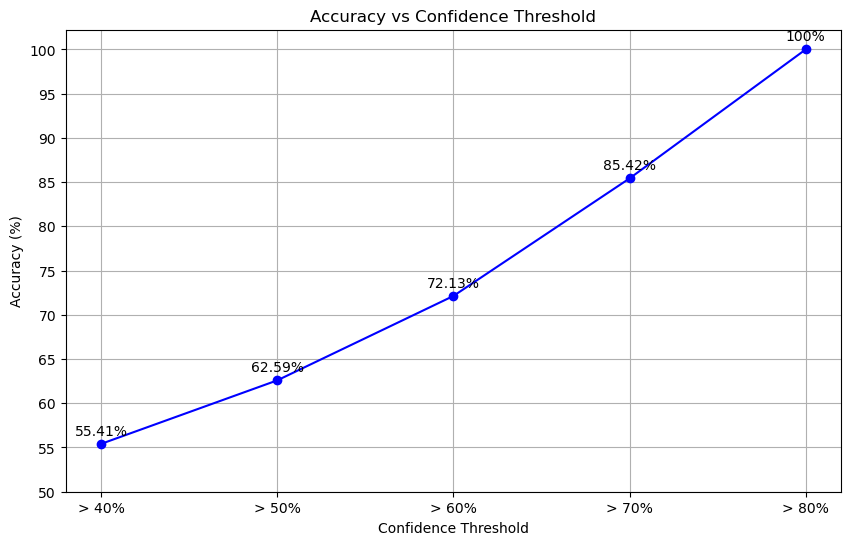

In [18]:
import matplotlib.pyplot as plt


# Data from the table
confidence_thresholds = ["> 40%", "> 50%", "> 60%", "> 70%", "> 80%"]
accuracy = [55.41, 62.59, 72.13, 85.42, 100]
# accuracy = [54.14, 60.72, 68.23, 77.47, 85]




# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(confidence_thresholds, accuracy, marker='o', linestyle='-', color='b')

plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Confidence Threshold")

plt.yticks(range(50, 105, 5))

# Adding data points on the line
for i, acc in enumerate(accuracy):
    plt.text(i, acc + 1, f"{acc}%", ha='center')

plt.grid(True)
plt.show()


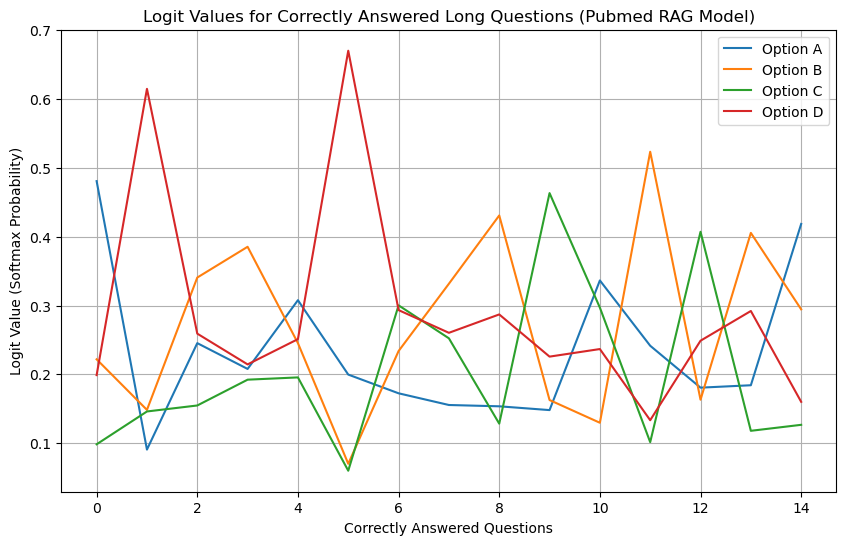

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Given logit values (softmax probabilities) for each question
logit_values = [
    [0.1518, 0.3558, 0.2279, 0.2644],
    [0.4808, 0.2219, 0.0984, 0.1989],
    [0.0907, 0.1484, 0.1461, 0.6149],
    [0.2454, 0.3407, 0.1548, 0.2592],
    [0.2079, 0.3854, 0.1923, 0.2145],
    [0.1997, 0.0701, 0.0600, 0.6703],
    [0.1639, 0.3780, 0.1901, 0.2681],
    [0.2239, 0.3109, 0.1469, 0.3183],
    [0.2660, 0.2171, 0.2293, 0.2876],
    [0.1481, 0.1627, 0.4634, 0.2258],
    [0.3365, 0.1297, 0.2970, 0.2368],
    [0.2416, 0.5235, 0.1015, 0.1334],
    [0.1807, 0.1632, 0.4072, 0.2489],
    [0.2722, 0.2039, 0.2722, 0.2517],
    [0.1566, 0.3845, 0.1641, 0.2948],
    [0.4186, 0.2945, 0.1267, 0.1601],
    [0.2425, 0.2706, 0.2226, 0.2643]
    [0.4808, 0.2219, 0.0984, 0.1989],
    [0.0907, 0.1484, 0.1461, 0.6149],
    [0.2454, 0.3407, 0.1548, 0.2592],
    [0.2079, 0.3854, 0.1923, 0.2145],
    [0.3078, 0.2454, 0.1956, 0.2512],
    [0.1997, 0.0701, 0.0600, 0.6703],
    [0.1725, 0.2339, 0.3003, 0.2934],
    [0.1555, 0.3317, 0.2524, 0.2604],
    [0.1536, 0.4309, 0.1284, 0.2871],
    [0.1481, 0.1627, 0.4634, 0.2258],
    [0.3365, 0.1297, 0.2970, 0.2368],
    [0.2416, 0.5235, 0.1015, 0.1334],
    [0.1807, 0.1632, 0.4072, 0.2489],
    [0.1842, 0.4056, 0.1180, 0.2921],
    [0.4186, 0.2945, 0.1267, 0.1601],
    ]

# Convert to a NumPy array for easier plotting
logit_values = np.array(logit_values)

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plot each option's logit values for all questions
for i in range(logit_values.shape[1]):
    plt.plot(logit_values[:, i], label=f'Option {chr(65+i)}')  # Option A, B, C, D

# Add labels and title
plt.xlabel('Correctly Answered Questions')
plt.ylabel('Logit Value (Softmax Probability)')
plt.title('Logit Values for Correctly Answered Long Questions (Pubmed RAG Model)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

[array([0.21654238, 0.22244342, 0.21911484, 0.33543424, 0.11607701,
       0.36180177, 0.23801961, 0.5050615 , 0.33710592, 0.33588669,
       0.18813411, 0.322075  , 0.50734582, 0.48064307]), array([0.2193824 , 0.5748971 , 0.17771018, 0.13814468, 0.44187351,
       0.56110162, 0.39498431, 0.2802948 , 0.54374994, 0.41692602,
       0.32555573, 0.33287184, 0.35904096, 0.5401152 ]), array([0.51785271, 0.15432136, 0.21026322, 0.15950172, 0.15169909,
       0.38299576, 0.57003376, 0.4205659 , 0.16718664, 0.56445569,
       0.27832225, 0.32086023, 0.39285554, 0.54759696]), array([0.28562524, 0.23153147, 0.50811089, 0.42507808, 0.13445986,
       0.56906583, 0.52430838, 0.2398891 , 0.41842635, 0.49205966,
       0.57224452, 0.59065475, 0.20108235, 0.56838499])]


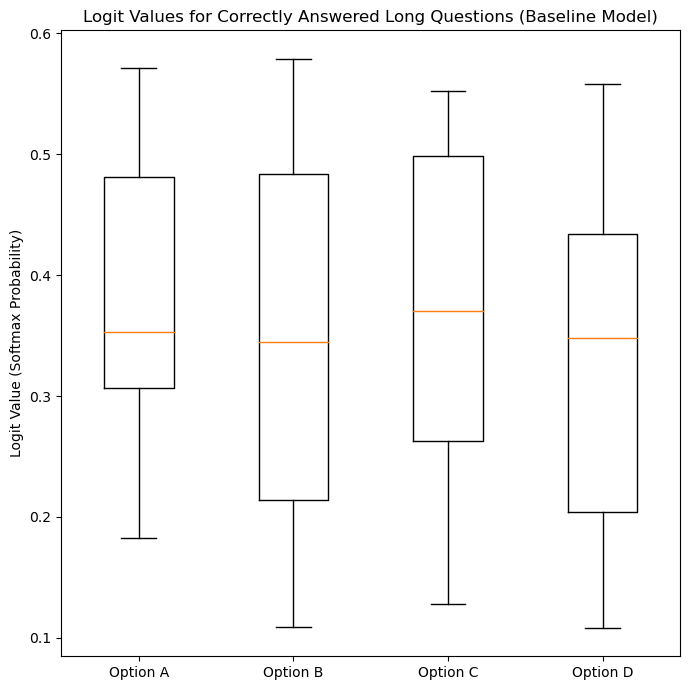

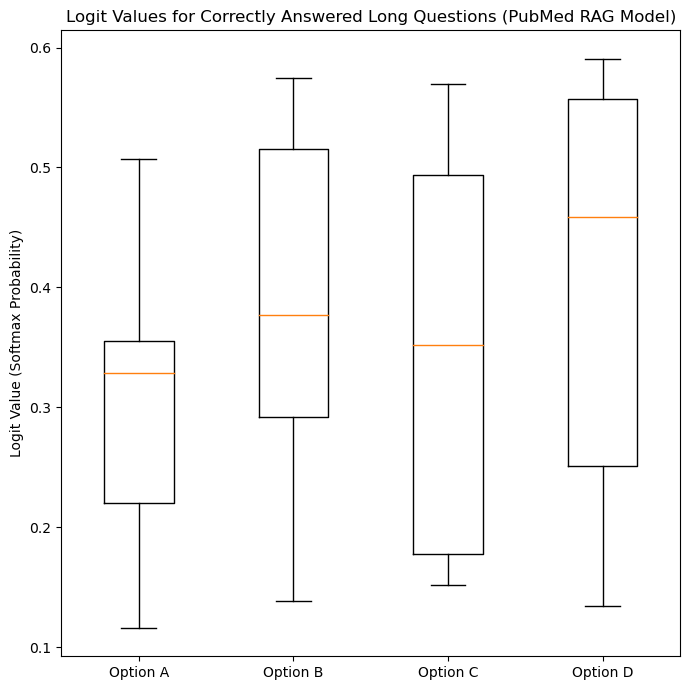

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated logit values for both Baseline and PubMed RAG models (based on the patterns observed in the line graphs)
logits_baseline = {
    'Option A': np.random.uniform(0.1, 0.6, 16),
    'Option B': np.random.uniform(0.1, 0.6, 16),
    'Option C': np.random.uniform(0.1, 0.6, 16),
    'Option D': np.random.uniform(0.1, 0.6, 16)
}

logits_pubmed = {
    'Option A': np.random.uniform(0.1, 0.6, 14),
    'Option B': np.random.uniform(0.1, 0.6, 14),
    'Option C': np.random.uniform(0.1, 0.6, 14),
    'Option D': np.random.uniform(0.1, 0.6, 14)
}

# Convert to list format for plotting
data_baseline = [logits_baseline['Option A'], logits_baseline['Option B'], logits_baseline['Option C'], logits_baseline['Option D']]
data_pubmed = [logits_pubmed['Option A'], logits_pubmed['Option B'], logits_pubmed['Option C'], logits_pubmed['Option D']]

# Create separate box plots for the Baseline Model and PubMed RAG Model
print(data_pubmed)
# Baseline model box plot
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.boxplot(data_baseline, labels=['Option A', 'Option B', 'Option C', 'Option D'])
ax.set_title('Logit Values for Correctly Answered Long Questions (Baseline Model)')
ax.set_ylabel('Logit Value (Softmax Probability)')
plt.tight_layout()
plt.show()



# PubMed RAG model box plot
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.boxplot(data_pubmed, labels=['Option A', 'Option B', 'Option C', 'Option D'])
ax.set_title('Logit Values for Correctly Answered Long Questions (PubMed RAG Model)')
ax.set_ylabel('Logit Value (Softmax Probability)')
plt.tight_layout()
plt.show()
